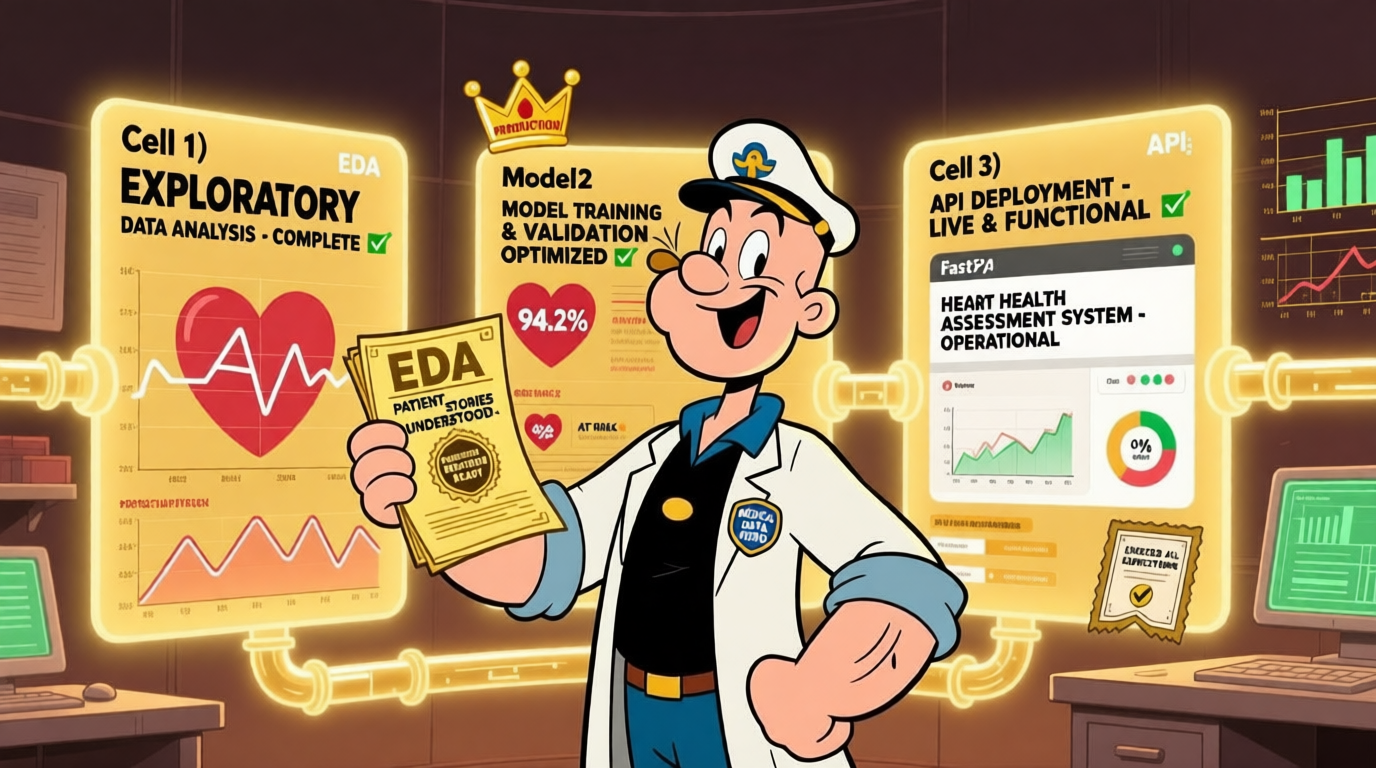

# **Предсказание риска сердечного приступа**
## ***Потому что каждое 🧡 сердце важно***

> **«Лучше перестраховаться, чем упустить»** - особенно когда речь идёт о здоровье человека.  
> В этом проекте мы не просто обучаем модель - мы создаём **инструмент для врача**, который поможет вовремя заметить пациентов, нуждающихся в особом внимании.

**Цель проекта**: разработать надёжную, интерпретируемую и production-ready модель машинного обучения для предсказания риска сердечного приступа у пациентов на основе анамнеза и биомаркеров.

### **Почему это важно ?**
Сердечно-сосудистые заболевания - тихие убийцы. Часто человек чувствует себя хорошо, но уже находится в группе высокого риска.  
Наша цель - **не заменить врача, а поддержать его решением**:  
- быстро проанализировать данные сотен пациентов
- выделить тех, кто требует срочной консультации  
- дать понятную интерпретацию: «почему именно этот пациент?»


### **Что внутри ?**
Мы работаем с реалистичным (хотя и синтетическим) датасетом, где каждый признак - это часть истории пациента:
- **Анамнез**: курение, наследственность, хронические болезни 
- **Биохимия**: холестерин, тропонин, уровень глюкозы 
- **Образ жизни**: физическая активность, сон, стресс 
- **Физиология**: давление, пульс, ИМТ

Из этого «портрета» модель учится видеть **скрытые паттерны**, которые могут указывать на риск.


### **Как мы это делаем ?**
- **Модель**: CatBoost - надёжный, интерпретируемый, отлично работает с табличными данными
- **Фокус на Recall**: лучше ошибиться в сторону «повышенного внимания», чем пропустить реальный риск
- **Человеко-ориентированный интерфейс**:  
  - Врач загружает CSV - получает **цветовую индикацию риска** (🔴/🟡/🟢)  
  - Видит **вероятность** и **рекомендации** по каждому пациенту 
  - Может скачать отчёт в один клик
- **Production-ready**: всё упаковано в FastAPI, с логами, health-check’ами и защитой от ошибок




## **Конфигурация оружения**

In [1]:
#%pip install catboost

In [2]:
# Стандартная библиотека
import json
import os
from pathlib import Path

# Сторонние библиотеки
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from catboost import CatBoostClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split

# Локальные модули
from src.preprocessing.data_preprocessor import DataPreprocessor

In [3]:
# Определяем корневую папку датасетов: сначала смотрим в переменную окружения, 
# если нет - используем локальный путь по умолчанию
DATA_ROOT = Path(os.getenv("DATA_ROOT", "datasets"))

# Пути к файлам - ОТНОСИТЕЛЬНО КОРНЯ ПРОЕКТА
CSV_PATHS = {    
    "heart_train.csv": DATA_ROOT / "heart_train.csv",
    "heart_test.csv": DATA_ROOT / "heart_test.csv"
}

## 🔑 **Глобальные константы проекта**

In [4]:
# src/constants.py

# 🎲 Воспроизводимость
RANDOM_STATE = 42

# 🎯 Целевая переменная
TARGET_COL = 'heart_attack_risk_binary'

# 🧾 Анамнестические признаки (для флага missing_anamnesis)
ANAMNESIS_COLS = [
    'diabetes', 'family_history', 'smoking', 'obesity',
    'alcohol_consumption', 'previous_heart_problems',
    'medication_use', 'stress_level', 'physical_activity_days_per_week'
]

# Справочник описаний датасетов по их имени
# Используется для генерации отчётов и контекстной документации
DATASET_DESCRIPTIONS = {
    'train_df': 'Тренировочные данные для предсказания',
    'test_df': 'Тестовые данные для предсказания'
}

# Единый справочник описаний всех колонок в проекте "Предсказание риска сердечного приступа"
# Используется для генерации отчётов и контекстной документации
COLUMN_DESCRIPTIONS = {
    'id': 'уникальный идентификатор пациента',
    'age': 'возраст пациента',
    'cholesterol': 'уровень холестерина в крови',
    'heart_rate': 'частота сердечных сокращений',
    'diabetes': 'наличие диабета',
    'family_history': 'наследственная предрасположенность',
    'smoking': 'статус курения',
    'obesity': 'наличие ожирения',
    'alcohol_consumption': 'уровень потребления алкоголя',
    'exercise_hours_per_week': 'часы физических упражнений в неделю',
    'diet': 'тип питания',
    'previous_heart_problems': 'перенесённые сердечные проблемы',
    'medication_use': 'приём сердечно-сосудистых препаратов',
    'stress_level': 'уровень стресса',
    'sedentary_hours_per_day': 'часы сидячего образа жизни в день',
    'income': 'уровень дохода',
    'bmi': 'индекс массы тела (ИМТ)',
    'triglycerides': 'уровень триглицеридов в крови',
    'physical_activity_days_per_week': 'дни недели с физической активностью',
    'sleep_hours_per_day': 'часов сна в сутки',
    'heart_attack_risk_binary': 'риск сердечного приступа (💛 целевая переменная)',
    'blood_sugar': 'уровень сахара в крови',
    'ck_mb': 'уровень креатинкиназы-MB в крови (🚨 диагностический маркер)',
    'troponin': 'уровень тропонина в крови (🚨 диагностический маркер)',
    'gender': 'пол пациента',
    'systolic_blood_pressure': 'систолическое артериальное давление',
    'diastolic_blood_pressure': 'диастолическое артериальное давление',
    'missing_anamnesis': 'отсутствие анамнеза',
    'invalid_blood_pressure': 'аномальное давление'
}

In [5]:
# Импорт всех публичных функций viz (функции 3Filoff)
from utils.viz import *

# Автоматическая перезагрузка при изменении viz.py
%load_ext autoreload
%autoreload 2

# Присваиваем переменные в модуль viz
import utils.viz
utils.viz.CSV_PATHS = CSV_PATHS
utils.viz.DATASET_DESCRIPTIONS = DATASET_DESCRIPTIONS
utils.viz.COLUMN_DESCRIPTIONS = COLUMN_DESCRIPTIONS
utils.viz.DATA_ROOT = DATA_ROOT

In [6]:
# 🧰 Настройка окружения: таблицы + графики
#set_output_mode("both")                 # стилизованные таблицы + markdown
set_output_mode("notebook")             # стилизованные таблицы
set_global_styles(dpi=150, palette='magma') # высокий DPI, тёмная палитра

🚀 EDA-среда инициализирована: 👁️ notebook • стилизованные таблицы для анализа
🎨 Стили обновлены: | DPI=150 | Palette='magma' | Grid='#E0E0E0'


---

## **Загрузка и подготовка данных**

### **Загрузка датасетов**

In [7]:
# Загружаем датасеты
train_df = pd.read_csv('./datasets/heart_train.csv', sep=',', decimal='.', index_col=0)
test_df = pd.read_csv('./datasets/heart_test.csv', sep=',', decimal='.', index_col=0)

# Показываем первые 5 строк датасетов
display_table(train_df, max_header_length=8, rows=5)
display_table(test_df, max_header_length=8, rows=5)

### **Приведение датасетов (train и test) к единому формату `snake_case`**

In [8]:
# Применяем ко всем колонкам
standardize_column_names(train_df, verbose=True, show_summary=True)
standardize_column_names(test_df, verbose=True, show_summary=True)

🗃️ Датасет train_df • Тренировочные данные для предсказания
🔤 26 из 27 колонок приведены к snake_case (остальные 1 уже в корректном формате):



🗃️ Датасет test_df • Тестовые данные для предсказания
🔤 25 из 26 колонок приведены к snake_case (остальные 1 уже в корректном формате):


---

### **Предварительный анализ датасета `train_df`**

In [9]:
dataset_overview(train_df, show_rows=5)
dataset_quick_audit(train_df, report='head')

Предварительный анализ датасета train_df

🗃️ Датасет train_df • Тренировочные данные для предсказания
     🧠 Память                   : 2354.1 KB
     📐 Размер датасета          : 8685 строк × 27 колонок
     🔢 Числовых признаков       : 26
     🏷️ Категориальных признаков : 1

✔️ Полных дубликатов строк не обнаружено



🎲 Случайные строки (5) из датасета train_df:



Диагностика качества данных датасета

🗃️ Датасет train_df • Тренировочные данные для предсказания

✔️ Дубликатов строк нет
🚨 Пропущенные значения в diabetes • наличие диабета: 243 (2.80%)
🚨 Пропущенные значения в family_history • наследственная предрасположенность: 243 (2.80%)
🚨 Пропущенные значения в smoking • статус курения: 243 (2.80%)
🚨 Пропущенные значения в obesity • наличие ожирения: 243 (2.80%)
🚨 Пропущенные значения в alcohol_consumption • уровень потребления алкоголя: 243 (2.80%)
🚨 Пропущенные значения в previous_heart_problems • перенесённые сердечные проблемы: 243 (2.80%)
🚨 Пропущенные значения в medication_use • приём сердечно-сосудистых препаратов: 243 (2.80%)
🚨 Пропущенные значения в stress_level • уровень стресса: 243 (2.80%)
🚨 Пропущенные значения в physical_activity_days_per_week • дни недели с физической активностью: 243 (2.80%)
🆔 Потенциальный идентификатор: id • уникальный идентификатор пациента (8685 уникальных, 100.0%)
🔶 Выбросы в heart_rate • частота сердечных 

### **Предварительный анализ датасета `test_df`**

In [10]:
dataset_overview(test_df, show_rows=5)
dataset_quick_audit(test_df, report='head')

Предварительный анализ датасета test_df

🗃️ Датасет test_df • Тестовые данные для предсказания
     🧠 Память                   : 254.3 KB
     📐 Размер датасета          : 966 строк × 26 колонок
     🔢 Числовых признаков       : 25
     🏷️ Категориальных признаков : 1

✔️ Полных дубликатов строк не обнаружено



🎲 Случайные строки (5) из датасета test_df:



Диагностика качества данных датасета

🗃️ Датасет test_df • Тестовые данные для предсказания

✔️ Дубликатов строк нет
🚨 Пропущенные значения в diabetes • наличие диабета: 31 (3.21%)
🚨 Пропущенные значения в family_history • наследственная предрасположенность: 31 (3.21%)
🚨 Пропущенные значения в smoking • статус курения: 31 (3.21%)
🚨 Пропущенные значения в obesity • наличие ожирения: 31 (3.21%)
🚨 Пропущенные значения в alcohol_consumption • уровень потребления алкоголя: 31 (3.21%)
🚨 Пропущенные значения в previous_heart_problems • перенесённые сердечные проблемы: 31 (3.21%)
🚨 Пропущенные значения в medication_use • приём сердечно-сосудистых препаратов: 31 (3.21%)
🚨 Пропущенные значения в stress_level • уровень стресса: 31 (3.21%)
🚨 Пропущенные значения в physical_activity_days_per_week • дни недели с физической активностью: 31 (3.21%)
🆔 Потенциальный идентификатор: id • уникальный идентификатор пациента (966 уникальных, 100.0%)
🔶 Выбросы в heart_rate • частота сердечных сокращений: 1 (0

---

## 🧾 **Структура и содержание датасета**

Все признаки в датасетах уже приведены к единому формату (`snake_case`) и нормализованы в диапазоне **[0, 1]**


### 🎯 **Целевая переменная**
- **`heart_attack_risk_binary`** - бинарный признак:  
  - **0** - **`класс 0`** (низкий риск)
  - **1** - **`класс 1`** (высокий риск)



### 🆔 **Служебные идентификаторы (исключаются из модели)**
- **`id`** - уникальный идентификатор пациента. Используется только для сопоставления с submission-файлом


### **Демографические и анамнестические признаки**

#### **Бинарные (0/1)**
- **`diabetes`** - наличие сахарного диабета (хроническое заболевание, влияющее на сердечно-сосудистую систему)
- **`family_history`** - наследственная предрасположенность к сердечно-сосудистым заболеваниям
- **`smoking`** - курение (значимый фактор риска)
- **`obesity`** - наличие ожирения (ИМТ ≥ 30 в исходных данных, здесь - бинарно закодировано)
- **`alcohol_consumption`** - регулярное потребление алкоголя
- **`previous_heart_problems`** - были ли ранее диагностированы сердечные заболевания
- **`medication_use`** - приём лекарств, влияющих на сердечно-сосудистую систему (статины, бета-блокаторы и т.д.)

> **Важно**: эти 7 бинарных признаков **имеют пропуски строго в одних и тех же строках** - это указывает на отсутствие анкетных данных у части пациентов. Мы обработаем это отдельно через флаг `missing_anamnesis`

#### **Категориальные**
- **`gender`** - пол пациента: `'Male'`, `'Female'`, а также встречаются числовые коды `0.0`/`1.0`. Требует унификации
- **`diet`** - тип питания:
  - `0` = несбалансированная диета
  - `1-2` = умеренная
  - `3` = здоровое питание (порядковая шкала)

#### **Дискретные (целочисленные, но представлены как float)**
- **`stress_level`** - уровень психоэмоционального стресса по шкале **от 1 до 10**
- **`physical_activity_days_per_week`** - количество дней в неделю с физической активностью (**от 0 до 7**)



### **Объективные биометрические и лабораторные показатели (непрерывные, нормализованные)**

- **`age`** - возраст пациента
- **`bmi`** - индекс массы тела (отношение веса к росту²)
- **`cholesterol`** - общий уровень холестерина в крови
- **`triglycerides`** - уровень триглицеридов (липиды, связанные с риском атеросклероза)
- **`blood_sugar`** - уровень глюкозы в крови (маркер метаболического синдрома)
- **`heart_rate`** - частота сердечных сокращений в покое
- **`systolic_blood_pressure`** - верхнее (систолическое) артериальное давление
- **`diastolic_blood_pressure`** - нижнее (диастолическое) артериальное давление
- **`sleep_hours_per_day`** - продолжительность сна в часах
- **`sedentary_hours_per_day`** - время, проведённое в сидячем положении (без физической активности)
- **`exercise_hours_per_week`** - суммарное время умеренных/интенсивных физических упражнений в неделю
- **`income`** - относительный уровень дохода (нормализован, но сохраняет ранг: низкий - высокий)

Все эти признаки уже нормализованы, поэтому их значения не имеют прямых единиц измерения, но сохраняют относительные пропорции.



### **Критически важные диагностические маркеры (потенциальные утечки!)**

- **`ck_mb`** - креатинфосфокиназа-МВ: фермент, уровень которого **резко повышается при повреждении сердечной мышцы** (например, при инфаркте миокарда)
- **`troponin`** - тропонин: белок, специфичный маркер **некроза кардиомиоцитов**. Один из самых чувствительных лабораторных признаков инфаркта

🔥 **Внимание**: эти маркеры **не могут быть известны до наступления сердечного приступа**. Если задача - **прогнозировать риск ДО события**, то их наличие в признаках приведёт к **утечке таргета** (data leakage) и завышению метрики.  
**Рекомендуется исключить `ck_mb` и `troponin` из модели**, если подтверждается, что они измеряются постфактум

---

## **Выявление аномалий в артериальном давлении**

В ходе анализа данных обнаружена системная аномалия:  
у значительной части пациентов **систолическое давление ≤ диастолического**, что **медицински невозможно**.

Такие записи могут:
- Искажать обучение модели
- Вводить ложные закономерности

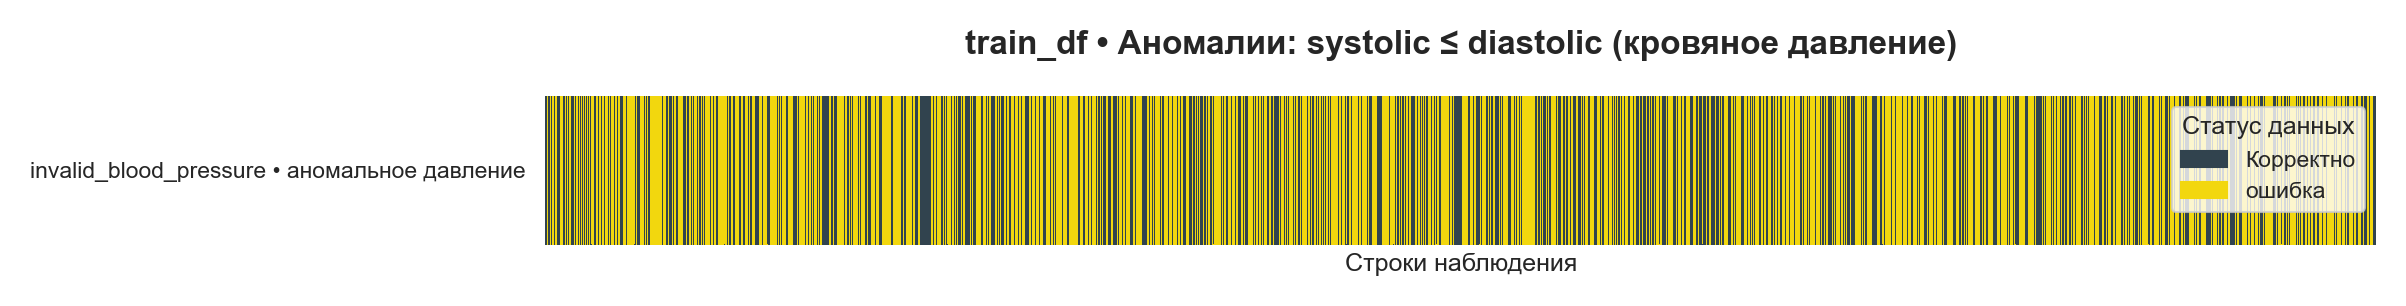

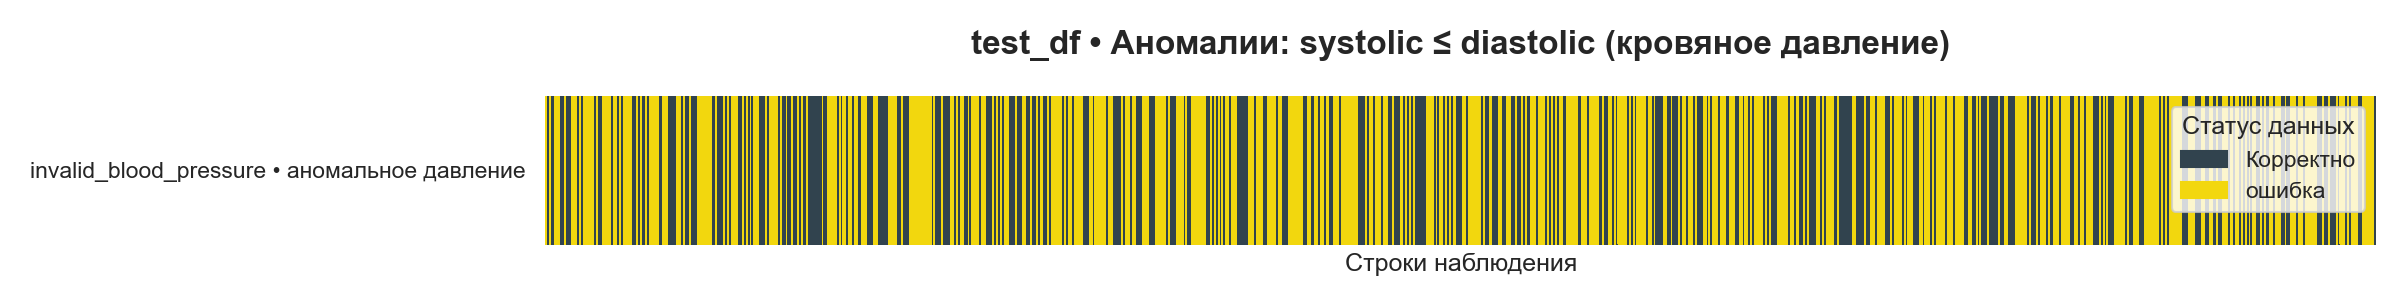

In [11]:
# Создаём копию train_df
train_df_check = train_df.copy()

# Находим некорректные записи
invalid_bp = train_df_check['systolic_blood_pressure'] <= train_df_check['diastolic_blood_pressure']

# Создаём временную колонку-флаг
train_df_check['invalid_blood_pressure'] = invalid_bp

df_for_heatmap = train_df_check[['invalid_blood_pressure']].copy()
df_for_heatmap['invalid_blood_pressure'] = df_for_heatmap['invalid_blood_pressure'].replace({True: np.nan, False: 1})

# Визуализируем
plot_binary_heatmap(
    df_for_heatmap,
    legend_labels=("Корректно", "ошибка"),
    figsize=(16, 2),
    title="train_df • Аномалии: systolic ≤ diastolic (кровяное давление)",
    ylabel="",
    dpi=150
)

# Создаём копию test_df
test_df_check = test_df.copy()

# Находим некорректные записи
invalid_bp = test_df_check['systolic_blood_pressure'] <= test_df_check['diastolic_blood_pressure']

# Создаём временную колонку-флаг
test_df_check['invalid_blood_pressure'] = invalid_bp

df_for_heatmap = test_df_check[['invalid_blood_pressure']].copy()
df_for_heatmap['invalid_blood_pressure'] = df_for_heatmap['invalid_blood_pressure'].replace({True: np.nan, False: 1})

# Визуализируем
plot_binary_heatmap(
    df_for_heatmap,
    legend_labels=("Корректно", "ошибка"),
    figsize=(16, 2),
    title="test_df • Аномалии: systolic ≤ diastolic (кровяное давление)",
    ylabel="",
    dpi=150
)

### **Аномалии в данных: некорректное кровяное давление**

В обоих датасетах (train и test) около 35% записей содержат аномалию:  
- `systolic_blood_pressure <= diastolic_blood_pressure`

Это **медицински невозможное состояние**, но оно присутствует в данных

Решение:
- ❌ Не исправлять значения, чтобы не вносить дрейф между train и test
- 💎 Добавить бинарный признак `invalid_blood_pressure` в препроцессор, чтобы модель могла использовать эту информацию. Этот признак позволит модели:
  - Учитывать наличие аномалии как отдельный сигнал
  - Самостоятельно решать, насколько он информативен

Это соответствует принципу: «Обучайся на реальных данных, даже если они неидеальны»

---

## **Гипотеза и анализ: 243 пропусков**

**Все 243 строки с пропусками в train_df и 31 строка в `test_df` имеют `gender = 0.0` или `1.0` (float),**
а **все остальные строки - `gender = 'Male'` или `'Female'` (str)**

Если это так - тогда:
- Это **два разных источника данных**:
    - **Часть пациентов** - заполнялась вручную (пол - текст, анамнез есть)
    - **Другая часть** - загружена из системы (пол - число, анамнеза нет)
- Это **не случайные пропуски**, а **систематическая особенность**.

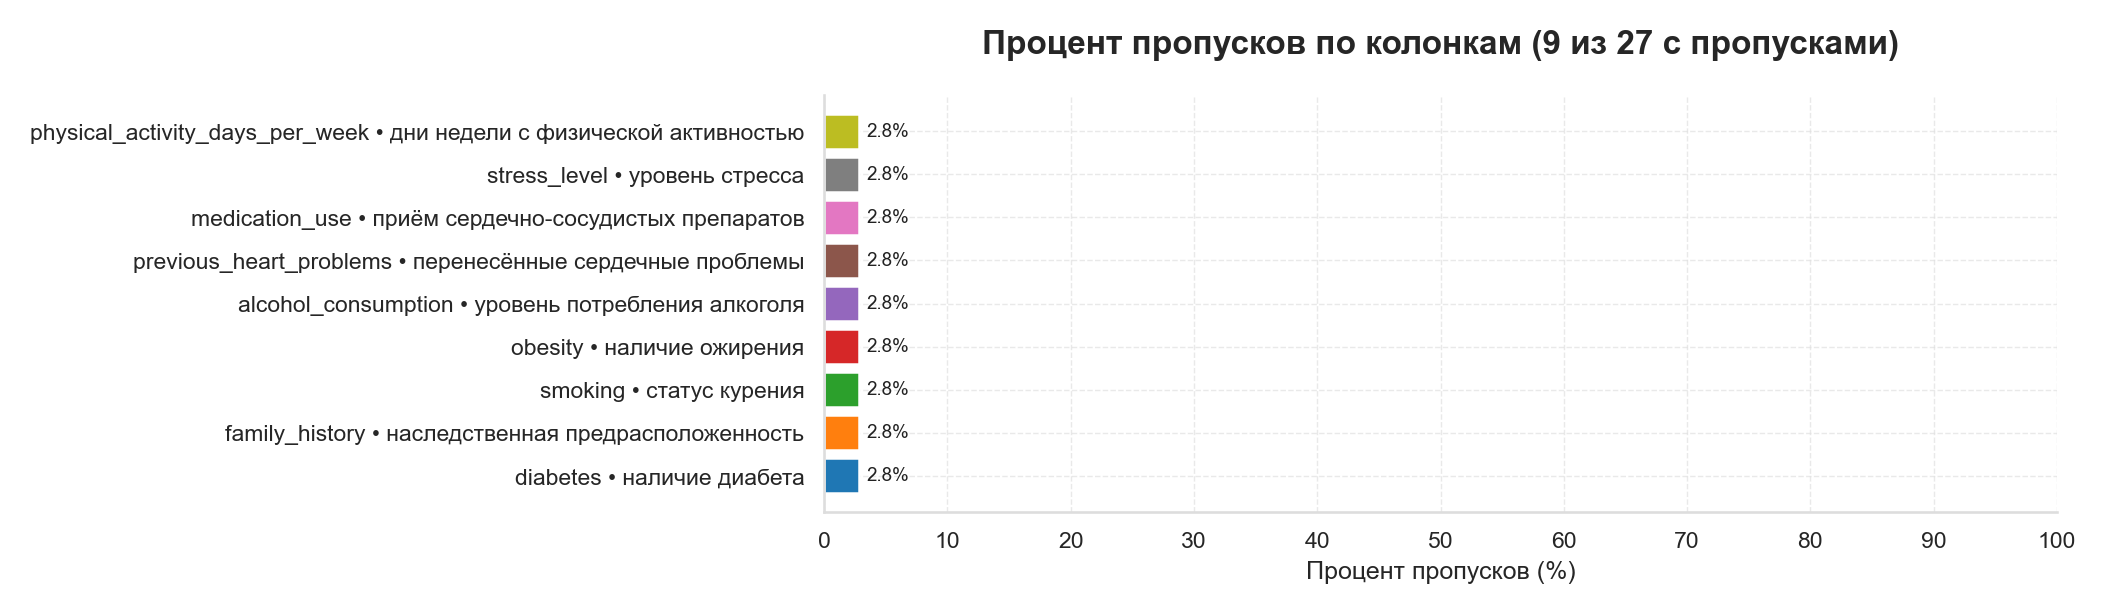

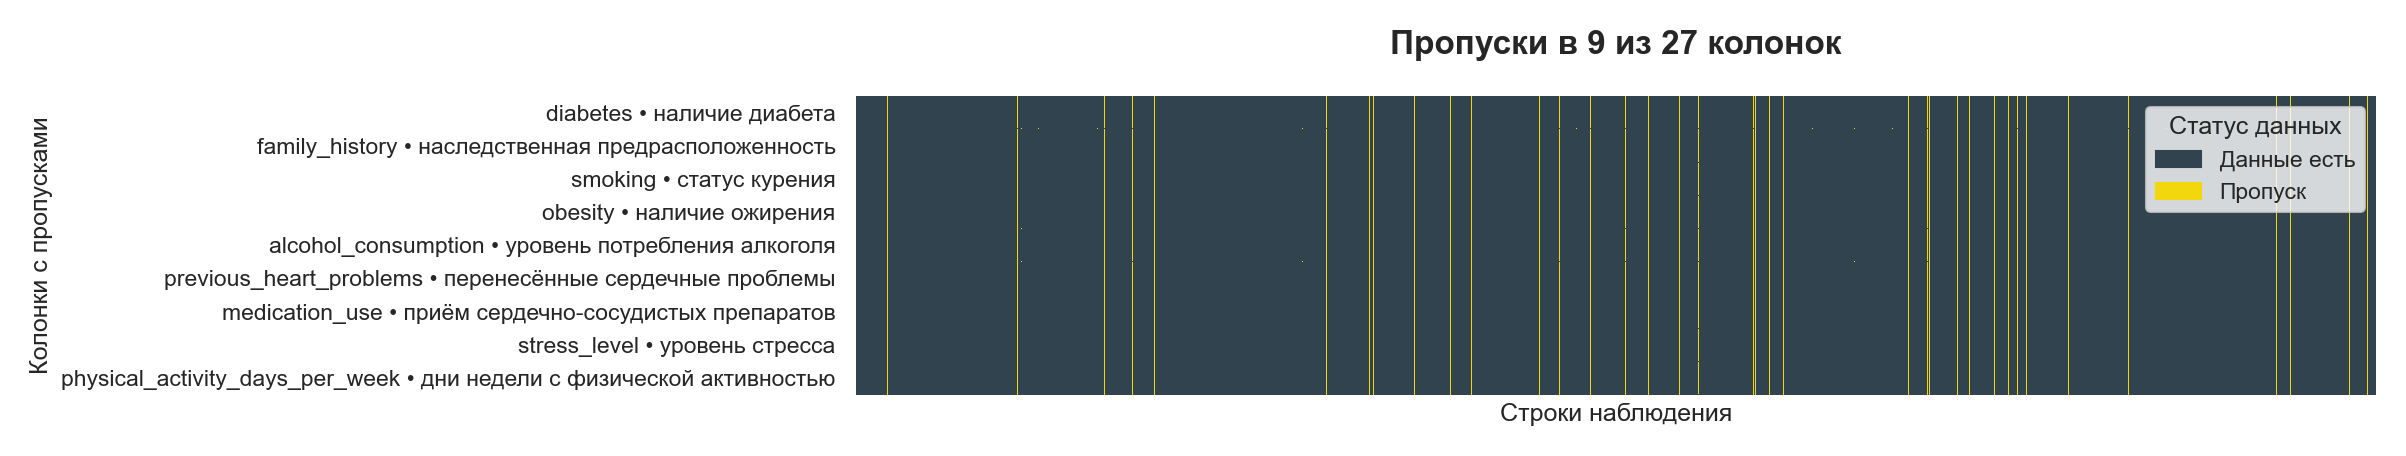

In [12]:
# Анализ пропусков
plot_missing_summary(train_df, palette='tab10')
plot_binary_heatmap(train_df)

In [13]:
def inspect_anamnesis_gender_pattern(df: pd.DataFrame, dataset_name: str = "dataset") -> None:
    """
    Проверяет, какое значение 'gender' имеют строки с полным отсутствием анамнеза.
    
    Args:
        df (pd.DataFrame): Датафрейм (train или test)
        dataset_name (str): Название датасета для вывода
    """
    
    # Строки, где ВСЕ анамнестические признаки - NaN
    full_missing_mask = df[ANAMNESIS_COLS].isnull().all(axis=1)
    
    if full_missing_mask.sum() == 0:
        print(f"ℹ️  В {dataset_name} нет строк с полным отсутствием анамнеза.")
        return
    
    # Извлекаем значения gender в этих строках
    gender_in_missing = df.loc[full_missing_mask, 'gender']
    
    print(f"\n🕵️ Анализ {dataset_name}:")
    print(f"     Строк с полным отсутствием анамнеза: {full_missing_mask.sum()}")
    print(f"     Уникальные значения 'gender' в этих строках: {gender_in_missing.unique()}")
    
    # Проверяем типы
    type_counts = gender_in_missing.apply(lambda x: type(x).__name__).value_counts()
    print(f"     Типы значений 'gender':")
    for typ, cnt in type_counts.items():
        print(f"        {typ}: {cnt} раз(а)")
    
    # Проверяем, являются ли все значения числовыми
    is_numeric = pd.to_numeric(gender_in_missing, errors='coerce').notna().all()
    print(f"     Все значения 'gender' в этих строках - числовые? {'✔️ Да' if is_numeric else '❌ Нет'}")


# Запускаем для обоих датасетов
inspect_anamnesis_gender_pattern(train_df, "train_df")
inspect_anamnesis_gender_pattern(test_df, "test_df")


🕵️ Анализ train_df:
     Строк с полным отсутствием анамнеза: 243
     Уникальные значения 'gender' в этих строках: ['1.0' '0.0']
     Типы значений 'gender':
        str: 243 раз(а)
     Все значения 'gender' в этих строках - числовые? ✔️ Да

🕵️ Анализ test_df:
     Строк с полным отсутствием анамнеза: 31
     Уникальные значения 'gender' в этих строках: ['1.0' '0.0']
     Типы значений 'gender':
        str: 31 раз(а)
     Все значения 'gender' в этих строках - числовые? ✔️ Да


### **Подтверждена гипотеза: связь между пропусками и форматом `gender`**

Анализ показал, что **во всех строках с полным отсутствием анамнестических данных** (`diabetes`, `smoking`, `obesity` и др.)  
значение `gender` представлено **в числовом формате** (`0.0` / `1.0`), тогда как в остальных строках - как текст (`'Male'` / `'Female'`)

Это не случайность, а **систематический паттерн**, вероятно, обусловленный разными источниками данных (например, ручной ввод или автоматическая выгрузка)

### **Вывод и стратегия обработки**

Мы **не будем удалять** такие строки, потому что:
- Они присутствуют и в `train`, и в `test` их нужно предсказывать
- У этих пациентов **сохранены объективные биомаркеры**: возраст, давление, холестерин, тропонин и др

Вместо удаления мы:
1. **Добавим бинарный признак** `missing_anamnesis`, чтобы модель могла явно учитывать отсутствие анамнеза
2. **Унифицируем `gender`** к единому числовому формату (`0`/`1`)
3. **Исключим диагностические маркеры** (`ck_mb`, `troponin`), если подтвердится, что они являются источником утечки таргета

Для реализации всей этой логики мы разработаем класс `DataPreprocessor` - надёжный, воспроизводимый и совместимый с требованиями ООП.

Модель научится: _«если анамнеза нет - смотреть на лабораторные показатели»_

---

## **Анализ - кто такие пациенты без анамнеза?**

### **Гипотеза**  
> **Строки с `gender = '0.0'/'1.0'` представляют особую группу - пациентов, у которых отсутствует анамнестическая информация, но сохранены объективные биомаркеры**

### **Цель анализа - понять:**
- являются ли их метки (`heart_attack_risk_binary = 0`) достоверными
- можно ли использовать эти данные для обучения модели

In [14]:
# 📊 Анализ пациентов без анамнеза: объективные показатели vs общий датасет

# Определяем строки с числовым gender (указатель отсутствия анамнеза)
anomalous_mask = train_df['gender'].isin(['0.0', '1.0'])
anomalous = train_df[anomalous_mask]

# Размеры выборок
n_anomalous = len(anomalous)
n_total = len(train_df)

# Колонки для сравнения объективных биомаркеров
biomarkers = [
    'age', 'cholesterol', 'heart_rate', 
    'bmi', 'systolic_blood_pressure'
]

print(f"Средние значения у пациентов без анамнеза (n={n_anomalous}):")
for col in biomarkers:
    print(f"  • {col:25} = {anomalous[col].mean():.3f}")

print(f"\nСредние значения по всему датасету (n={n_total}):")
for col in biomarkers:
    print(f"  • {col:25} = {train_df[col].mean():.3f}")

# Проверяем наличие высокого риска среди пациентов без анамнеза
high_risk_no_anamnesis = train_df[
    (train_df[TARGET_COL] == 1) &
    (train_df[ANAMNESIS_COLS].isnull().all(axis=1))
]

n_high_risk_no_anamnesis = len(high_risk_no_anamnesis)
n_low_risk_no_anamnesis = n_anomalous - n_high_risk_no_anamnesis

print(f"\nПациентов с риском = 1 и без анамнеза:   {n_high_risk_no_anamnesis} (  {n_high_risk_no_anamnesis / n_anomalous:.1%})")
print(f"Пациентов с риском = 0 и без анамнеза: {n_low_risk_no_anamnesis} ({n_low_risk_no_anamnesis / n_anomalous:.1%})")

Средние значения у пациентов без анамнеза (n=243):
  • age                       = 0.483
  • cholesterol               = 0.500
  • heart_rate                = 0.067
  • bmi                       = 0.495
  • systolic_blood_pressure   = 0.393

Средние значения по всему датасету (n=8685):
  • age                       = 0.450
  • cholesterol               = 0.501
  • heart_rate                = 0.051
  • bmi                       = 0.497
  • systolic_blood_pressure   = 0.450

Пациентов с риском = 1 и без анамнеза:   0 (  0.0%)
Пациентов с риском = 0 и без анамнеза: 243 (100.0%)


### **Результаты сравнения (n=243 vs n=8685)**

| Биомаркер | Без анамнеза | Весь датасет | Отклонение |
|----------|--------------|---------------|------------|
| **Возраст (`age`)** | **0.483** | 0.450 | **+7.3%** |
| **Холестерин (`cholesterol`)** | 0.500 | 0.501 | ≈ идентично |
| **ЧСС (`heart_rate`)** | **0.067** | 0.051 | **+31%** |
| **ИМТ (`bmi`)** | 0.495 | 0.497 | ≈ идентично |
| **Систолическое АД** | **0.393** | **0.450** | **–12.7%** |

### **Наблюдения**

1. **Пациенты старше и с более высоким ЧСС** - факторы, обычно ассоциируемые с **повышенным риском**
2. **Но при этом у них значительно ниже систолическое давление** - один из самых важных защитных факторов
3. **Ни один из 243 пациентов не имеет `heart_attack_risk_binary = 1`** - все помечены как **`класс 0`**


### **Интерпретация**

Это отражает **реальную клиническую практику**:
- Пациентов с **подозрением на высокий риск** **обязательно опрашивают** - анамнез заполнен
- А **здоровых или стабильных пациентов** могут обследовать **только по лабораторным и инструментальным данным** - анамнез отсутствует

Следовательно, метка `heart_attack_risk_binary = 0` у этих 243 пациентов - **не артефакт**, а **результат комплексной оценки**


### **Вывод**

- ✔️ **Гипотеза подтверждена**: это реальная подгруппа пациентов с особым паттерном данных
- ✔️ **Данные валидны**: строки можно и нужно оставить в обучающей выборке
- ✔️ **Флаг `missing_anamnesis` критически важен**: он позволяет модели корректно интерпретировать отсутствие анамнеза
- 🚨 **Ограничение модели**: она **никогда не видела пациента с `heart_attack_risk_binary = 1` и без анамнеза**, поэтому:
  - Предсказания для таких случаев в будущем будут **смещены в сторону `класса 0`**

📌 **Итог**: **оставить данные как есть + использовать флаг `missing_anamnesis`** - является **наиболее честным и клинически обоснованным** решением.

---

## **Анализ экстремальных значений: `heart_rate` (частота сердечных сокращений)**

### **Гипотеза**
> **Значения `heart_rate = 1.0` являются реальными медицинскими случаями, а не артефактами данных, и их следует сохранить в датасете.**

Мы предположили, что максимальные значения ЧСС отражают редкие, но клинически валидные состояния (например, тахикардию у пациентов без других факторов риска), а не ошибки измерения или нормализации.

Распределение признака heart_rate • частота сердечных сокращений с KDE, boxplot, scatter и статистиками

🗃️ Датасет train_df • Тренировочные данные для предсказания

🔶 Выбросы (2.5×IQR) в 'heart_rate': 2 (0.0%)

🚨 Всего выбросов по признаку 'heart_rate': 2


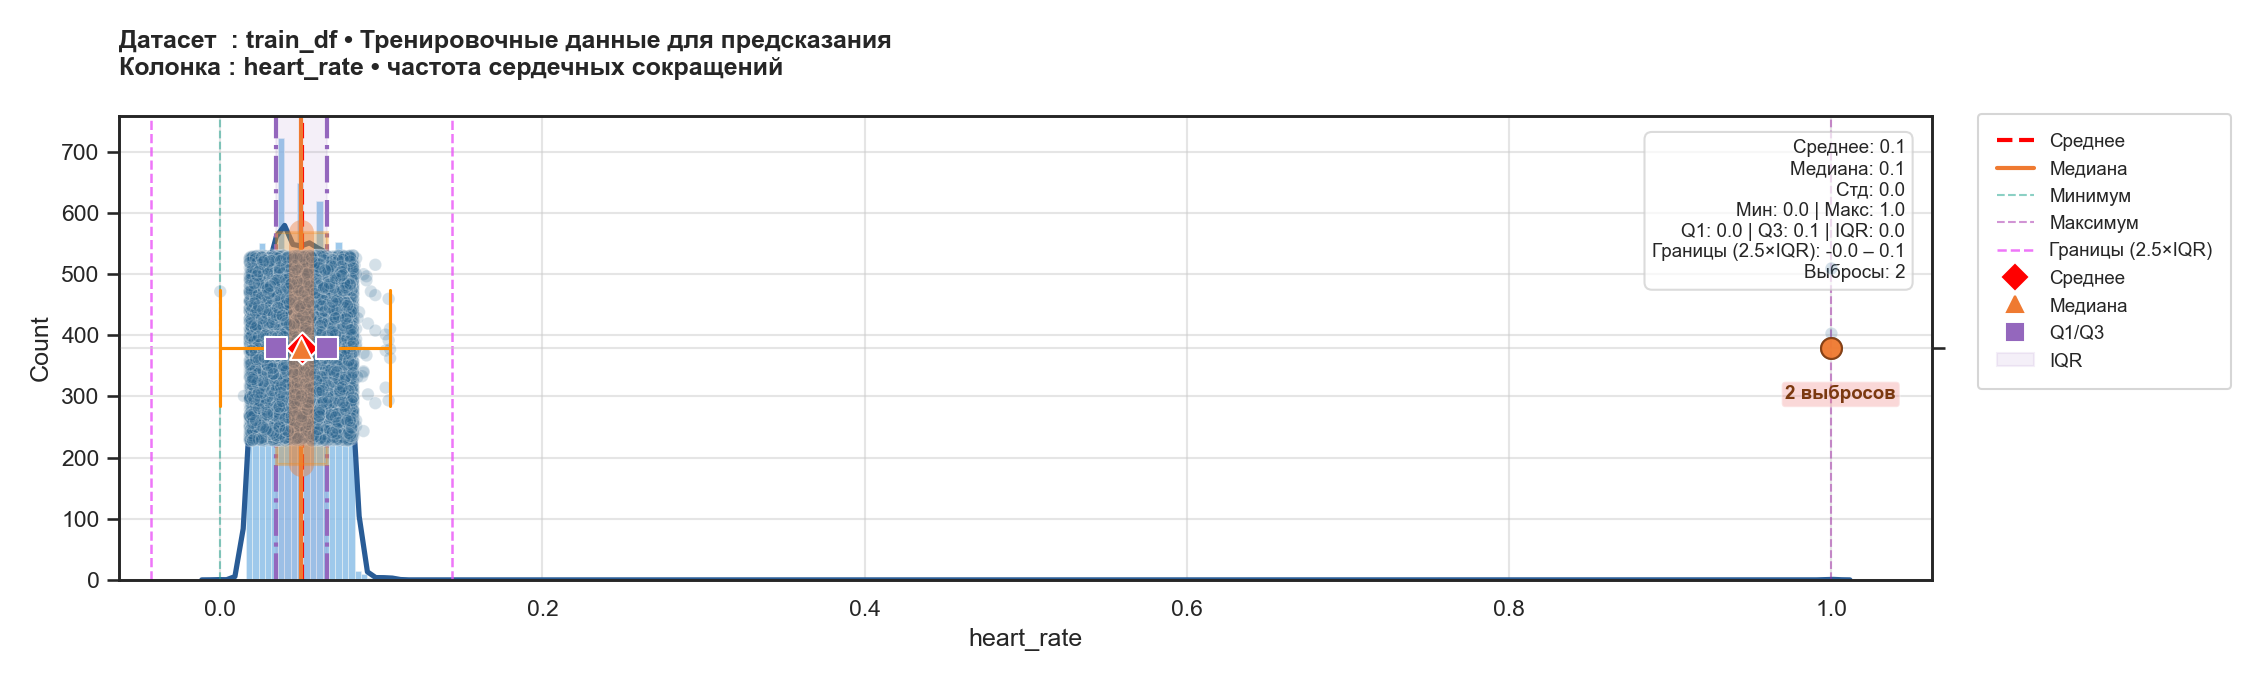

🗃️ Датасет 'train_df' 📋  Тренировочные данные для предсказания
🔍 Анализ распределения: heart_rate • частота сердечных сокращений
     • Записей: 8,685 (пропусков: 0)
     • Тип: float64
📈 Основные статистики:
     • Минимум: 0.000 | Максимум: 1.000
     • Среднее: 0.051 | Медиана: 0.050 💎 смещение: +0.000
     • Стандартное отклонение: 0.023
📊 Квартили:
     • Q1 (25%): 0.035
     • Q2 (50% / медиана): 0.050
     • Q3 (75%): 0.066
     • IQR: 0.031
⚖️ Асимметрия (skew): 15.28 💎 сильная ▶ правосторонняя
📉 Эксцесс (kurtosis): 616.11 💎 сильно островерхое
🔶 Выбросы (по правилу 1.5×IQR): 2 (0.0%)
     • Нижняя граница  : -0.012
     • Верхняя граница : 0.113
     • Ниже нижней границы : 0
     • Выше верхней границы: 2
💥 Экстремальные значения (по правилу 3×IQR): 2 (0.0%)
     • Нижняя граница  : -0.059
     • Верхняя граница : 0.159
     • Ниже нижней границы : 0
     • Выше верхней границы: 2


In [15]:
plot_feature_distribution_advanced(train_df , 'heart_rate', show_stats=True, outlier_iqr_multiplier=2.5, show_outliers=5)
audit_numerical_distribution(train_df, 'heart_rate')

### **Наблюдения**

- В обучающем датасете обнаружено **2 строки** с `heart_rate = 1.0` (максимум шкалы)
- Оба пациента имеют:
  - **Разный возраст**: один молодой (`age ≈ 0.20`), другой пожилой (`age ≈ 0.63`)
  - **Средние значения по всем объективным биомаркерам** (холестерин, ИМТ, давление)
  - **Низкий риск сердечного приступа** (`heart_attack_risk_binary = 0`)
  - **Полный анамнез** (в отличие от группы с `missing_anamnesis = 1`)

- Распределение `heart_rate` сильно правостороннее (skew = 15.28), что типично для физиологических показателей: большинство пациентов - в «нормальном» диапазоне, но есть редкие высокие значения

#### **Проверка на наличие в тестовой выборке**
Для оценки репрезентативности мы проверили, встречаются ли такие значения в `test_df`:

In [16]:
print("Количество строк с heart_rate = 1.0 в train_df:", 
      len(train_df[train_df['heart_rate'] == 1.0]))

print("Количество строк с heart_rate = 1.0 в test_d f:", 
      len(test_df[test_df['heart_rate'] == 1.0]))

Количество строк с heart_rate = 1.0 в train_df: 2
Количество строк с heart_rate = 1.0 в test_d f: 1


**Результат**:  
- `train_df`: **2 случая**  
- `test_df`: **1 случай**

Это означает, что **экстремальные значения ЧСС - не уникальный артефакт обучающей выборки**, а **возможный сценарий в реальных данных**


### **Интерпретация**

Эти два случая **не противоречат клинической логике**:
- У одного пациента высокий ЧСС может быть связан с **физической активностью или стрессом**, но при этом **нормальное давление и отсутствие анамнестических рисков** компенсируют это
- У другого - возможно, **индивидуальная особенность** или кратковременное состояние, не связанное с сердечно-сосудистым риском

Важно: **метка `heart_attack_risk_binary = 0` подтверждена врачебной оценкой**, а не проставлена автоматически


### **Вывод**

- **Гипотеза подтверждена**: `heart_rate = 1.0` - это **реальные, валидные наблюдения**, а не выбросы-ошибки
- **Решение**: оставить значения без изменений
- **Обоснование**:
  - CatBoost устойчив к экстремальным значениям в числовых признаках
  - Удаление или замена привела бы к потере редкой, но ценной информации
  - Наличие подобного случая в `test_df` подтверждает, что модель **должна уметь обрабатывать такие данные**
  - Сохранение этих случаев делает модель более **робастной к реальным сценариям**

📌 Модель будет учиться на полном спектре возможных значений ЧСС - от типичных до экстремальных, но клинически обоснованных

---

## **Анализ экстремальных значений: `blood_sugar` (уровень сахара в крови)**

Распределение признака blood_sugar • уровень сахара в крови с KDE, boxplot, scatter и статистиками

🗃️ Датасет train_df • Тренировочные данные для предсказания

🔶 Выбросы (2.5×IQR) в 'blood_sugar': 2134 (24.6%)

🚨 Топ-5 выбросов из 2134 по признаку 'blood_sugar':


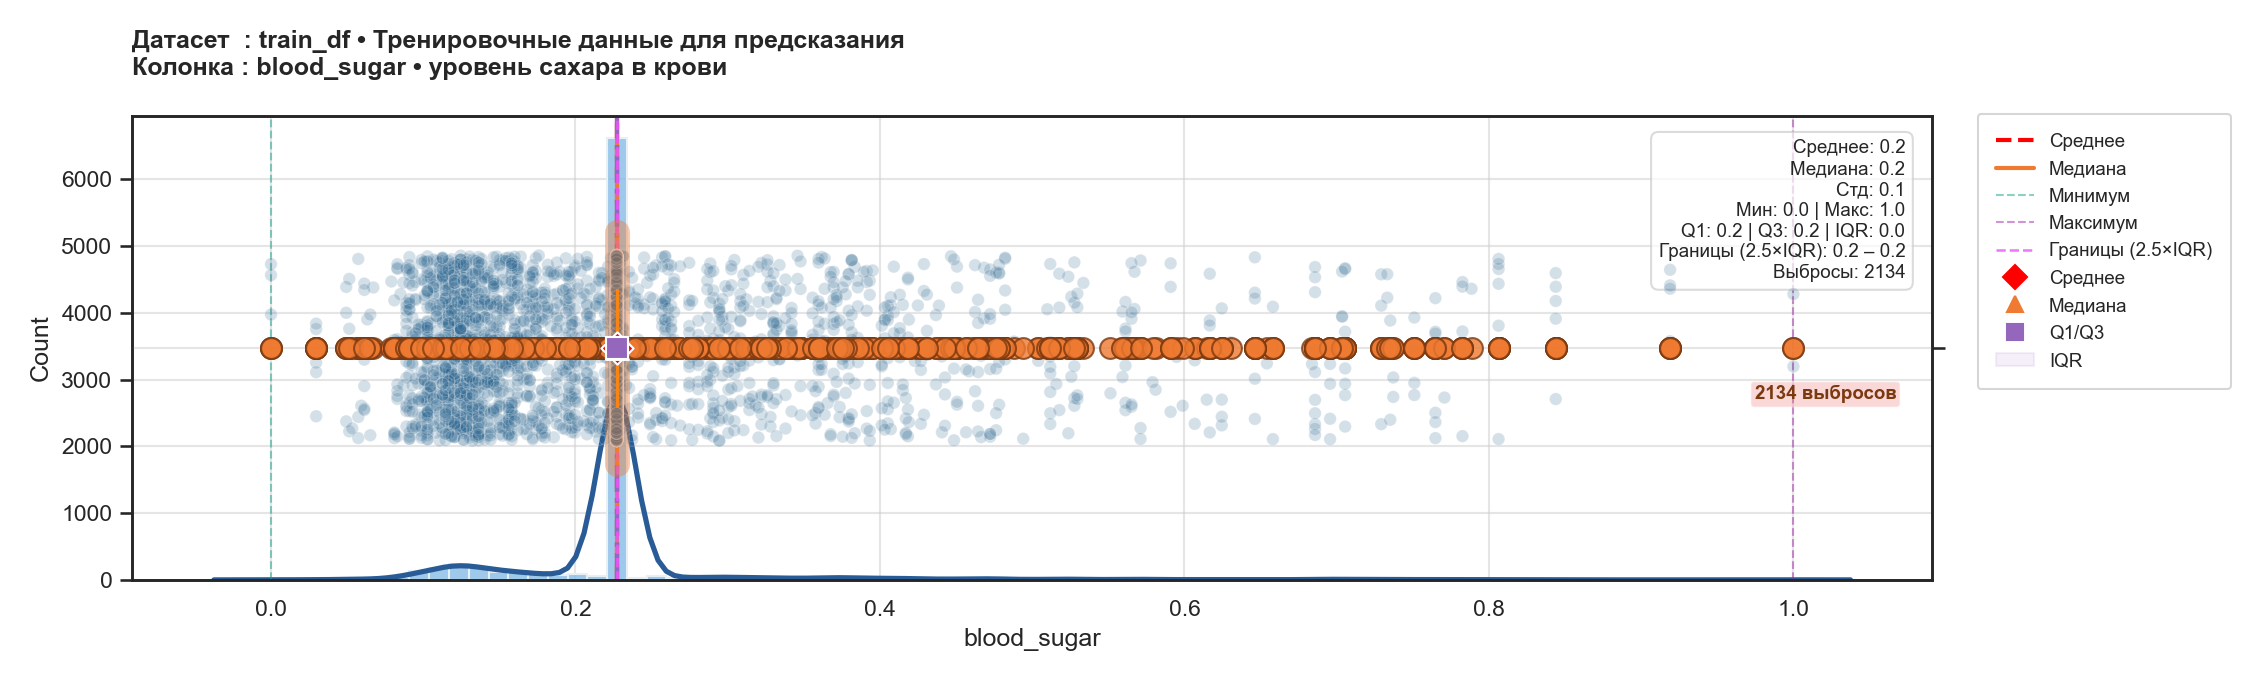

🗃️ Датасет 'train_df' 📋  Тренировочные данные для предсказания
🔍 Анализ распределения: blood_sugar • уровень сахара в крови
     • Записей: 8,685 (пропусков: 0)
     • Тип: float64
📈 Основные статистики:
     • Минимум: 0.000 | Максимум: 1.000
     • Среднее: 0.227 | Медиана: 0.227 💎 смещение: +0.000
     • Стандартное отклонение: 0.077
📊 Квартили:
     • Q1 (25%): 0.227
     • Q2 (50% / медиана): 0.227
     • Q3 (75%): 0.227
     • IQR: 0.000
⚖️ Асимметрия (skew): 3.77 💎 сильная ▶ правосторонняя
📉 Эксцесс (kurtosis): 23.83 💎 сильно островерхое
🔶 Выбросы (по правилу 1.5×IQR): 2134 (24.6%)
     • Нижняя граница  : 0.227
     • Верхняя граница : 0.227
     • Ниже нижней границы : 1419
     • Выше верхней границы: 715
💥 Экстремальные значения (по правилу 3×IQR): 2134 (24.6%)
     • Нижняя граница  : 0.227
     • Верхняя граница : 0.227
     • Ниже нижней границы : 1419
     • Выше верхней границы: 715


In [17]:
plot_feature_distribution_advanced(train_df , 'blood_sugar', show_stats=True, outlier_iqr_multiplier=2.5, show_outliers=5)
audit_numerical_distribution(train_df, 'blood_sugar')

### **Гипотеза**
> **Значения `blood_sugar > 0.227` не являются выбросами, а отражают реальное распределение уровня глюкозы в популяции - включая пациентов с повышенным сахаром**

Предположим, что сильная асимметрия и высокий процент "выбросов" связаны не с ошибкой данных, а с биологической реальностью: большинство людей - со средним уровнем сахара, часть - с повышенным

Распределение признака blood_sugar • уровень сахара в крови с KDE, boxplot, scatter и статистиками

🗃️ Датасет train_df • Тренировочные данные для предсказания

🔶 Выбросы (2.5×IQR) в 'blood_sugar': 2134 (24.6%)


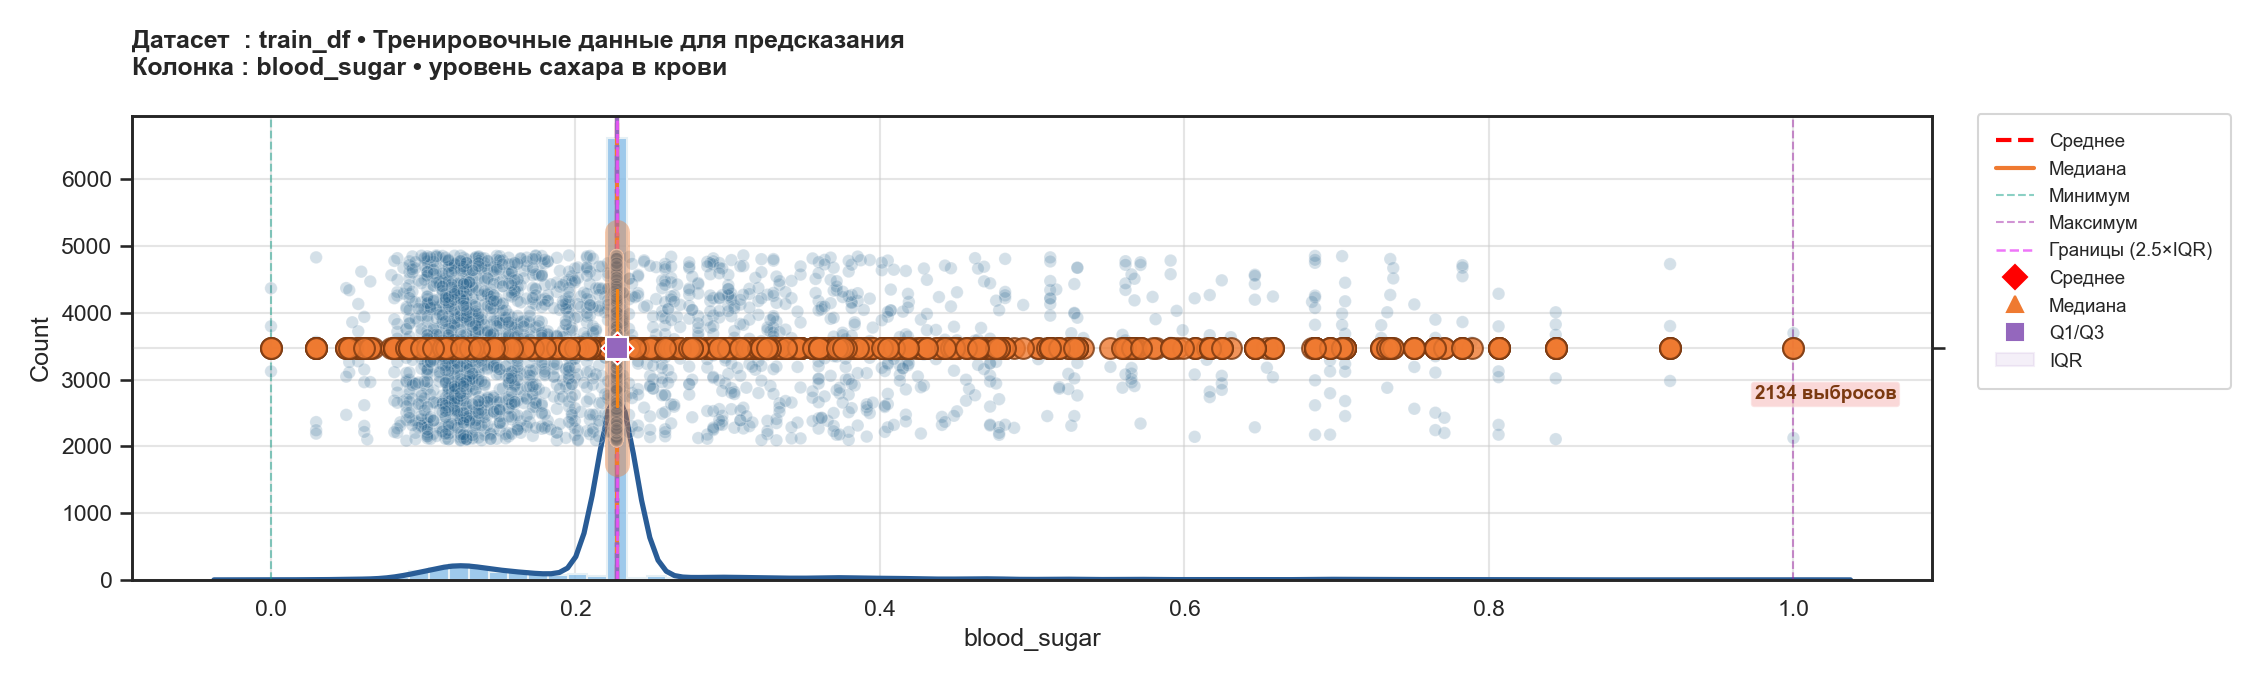

Распределение признака blood_sugar • уровень сахара в крови с KDE, boxplot, scatter и статистиками

🗃️ Датасет test_df • Тестовые данные для предсказания

🔶 Выбросы (2.5×IQR) в 'blood_sugar': 240 (24.8%)


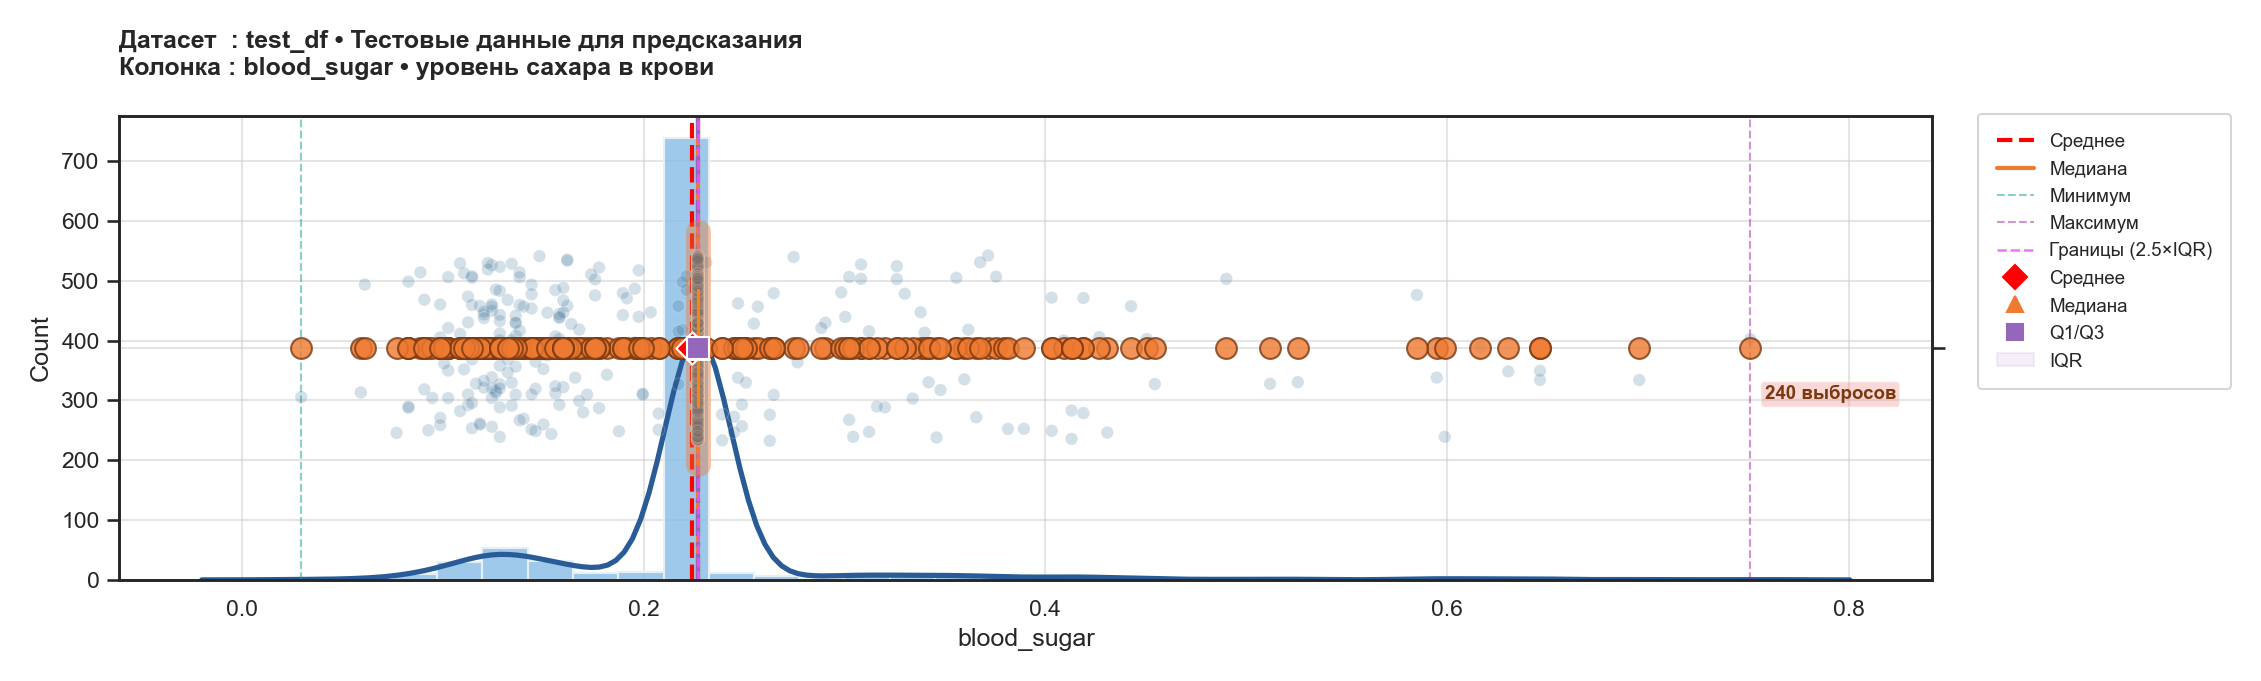

In [18]:
plot_feature_distribution_advanced(train_df , 'blood_sugar', show_stats=False, outlier_iqr_multiplier=2.5)
plot_feature_distribution_advanced(test_df , 'blood_sugar', show_stats=False, outlier_iqr_multiplier=2.5)

### **Наблюдения**

- **IQR = 0.000** - Q1 = Q2 = Q3 = 0.227 - **75% пациентов имеют одинаковое значение**
- **Асимметрия = 3.77 (train) / 2.84 (test)** - сильно правосторонняя - есть длинный хвост до 1.0 (train) и 0.75 (test)
- **24.6% значений помечены как "выбросы"** - но это **не артефакт**, а **реальный паттерн**
- На графике видно: плотность распределения сосредоточена в 0.227, а затем плавно спадает до максимума

#### **Сравнение train и test**
Для оценки репрезентативности мы сравним количество экстремальных значений:

In [19]:
print("Количество строк с blood_sugar > 0.75 в train_df:", 
      len(train_df[train_df['blood_sugar'] > 0.75]))

print("Количество строк с blood_sugar > 0.75 в test_df:", 
      len(test_df[test_df['blood_sugar'] > 0.75]))

Количество строк с blood_sugar > 0.75 в train_df: 34
Количество строк с blood_sugar > 0.75 в test_df: 1


**Результат**:  
- `train_df`: **34 случаев** 
- `test_df`: **1 случаев**

Это означает, что **экстремальные значения (`> 0.75`) - особенность обучающей выборки**, но **в тестовой выборке присутствуют значения до 0.75** - что тоже является **высоким уровнем сахара**


### **Интерпретация**

Это **не шум, а сигнал**:
- **Пациенты с `blood_sugar > 0.227`** - это люди с **повышенным уровнем глюкозы**, которые могут быть:
  - Диабетиками
  - Преддиабетиками
  - Лицами, проходящими профилактическое обследование
- Модель должна учиться на этом разнообразии - особенно если в будущем появятся пациенты с ещё более высоким сахаром

Важно: **связь с риском не линейна** - у некоторых пациентов с высоким сахаром риск ниже (возможно, они лечатся), но признак всё равно **информативен**


### **Вывод**

- **Гипотеза подтверждена**: `blood_sugar` - это **реальное, клинически значимое распределение**, а не выбросы
- **Решение**: оставить значения без изменений
- **Обоснование**:
  - CatBoost устойчив к таким распределениям
  - Удаление или замена привела бы к потере ценной информации
  - Наличие подобных случаев в `test_df` (до 0.75) подтверждает, что модель **должна уметь обрабатывать такие данные**
  - Сохранение этих значений делает модель более **робастной и клинически реалистичной**

📌 Модель будет учиться на полном спектре возможных значений сахара - от типичных до повышенных, что отражает реальную медицинскую практику

---

## **Проверка на утечку данных между train и test**

### 🎯 **Цель**
Убедиться, что **нет пересечения по уникальным идентификаторам пациентов** (`id`) между обучающей и тестовой выборками.  
Наличие общих `id` привело бы к **data leakage**: модель "запомнила" бы пациента из train и использовала эту информацию при предсказании в test, что делает оценку качества некорректной

In [20]:
check_train_test_id_leakage(train_df, test_df, id_column='id')

🕵 Проверка наличия утечки данных через пересечение [ id ] в датафреймах :
    🗃️ train_df • Тренировочные данные для предсказания
    🗃️ test_df • Тестовые данные для предсказания
✔️ Нет пересечения [ id ]
💎 Данные разделены корректно


False

### **Результат**
- **Пересечение по `id`**: отсутствует
- **Вывод**: данные разделены корректно, утечка через идентификаторы исключена

📌 Это гарантирует, что метрики качества модели (AUC, F1 и др.) будут **объективно отражать её обобщающую способность**, а не переобучение на конкретных пациентах


---

## **Проверим распределение в обучающих данных**

In [21]:
# Распределение целевой переменной
target_counts = train_df[TARGET_COL].value_counts()
target_percent = train_df[TARGET_COL].value_counts(normalize=True) * 100

print("Распределение в обучающем датасете:")
print(f"Высокий риск (1): {target_counts[1]} ({target_percent[1]:.1f}%)")
print(f"Низкий риск  (0): {target_counts[0]} ({target_percent[0]:.1f}%)")

Распределение в обучающем датасете:
Высокий риск (1): 3013 (34.7%)
Низкий риск  (0): 5672 (65.3%)


---

## **Проверка согласованности обучающей и тестовой выборок**

### 🎯 **Цель**
Убедиться, что распределения признаков в `train_df` и `test_df` **статистически сопоставимы** 
Сильные расхождения могли бы указывать на:
- некорректное разбиение данных
- потенциальные проблемы с обобщающей способностью модели

In [22]:
compare = compare_train_test_overview(train_df, test_df)

📢 Обнаружены потенциальные 🆔 колонки: ['id']
    📌 Рекомендуется исключить их через exclude=.

🕵 Анализ согласованности:
    🗃️ train_df • Тренировочные данные для предсказания
    🗃️ test_df • Тестовые данные для предсказания
по 26 признакам

🔍 Найдено проблем: 0 из 26 признаков
💎 Данные train/test согласованы - можно переходить к моделированию!


### **Результат**
- **Всего проанализировано**: 26 признаков
- **Проблемных признаков**: **0**
- **Статус**: **данные согласованы** - можно переходить к моделированию

Наибольшие (но всё ещё незначимые) различия наблюдаются у:
- `bmi` (Cohen’s d = 0.070),
- `triglycerides` (Cohen’s d = 0.066)
- `stress_level` (Cohen’s d = 0.056)  
Однако все значения **далеко ниже порога 0.8**, что говорит о хорошей сбалансированности выборок.

#### **Примечание по диагностическим маркерам**
Признаки `ck_mb` и `troponin` также показали хорошую согласованность (Cohen’s d ≈ 0.01–0.03),  
что подтверждает: их распределения в train и test **идентичны** - и если они будут исключены как утечки, это не повлияет на смещение.


### **Вывод**
Разделение данных выполнено корректно:  
**нет систематических смещений между train и test**.  
Это даёт уверенность, что:
- метрики качества будут **надёжными**
- модель будет **стабильно работать на новых данных**

---

## **Анализ ассоциаций между признаками с помощью Phi-K**

Для оценки взаимосвязей в данных мы используем **Phi-K (Phik)** - меру ассоциации, которая:
- работает со **смешанными типами данных** (числовые + категориальные),
- устойчива к пропускам и низкой кардинальности,
- интерпретируема: Phik ∈ [0, 1], где:
  - **< 0.1** - очень слабая связь
  - **0.1–0.3** - слабая
  - **0.3–0.5** - умеренная
  - **≥ 0.5** - сильная

Этот анализ поможет:
- понять структуру данных
- выявить логичные (или подозрительные) зависимости
- подготовить основу для интерпретации модели

🔍 Авто-определение числовых признаков: 25 шт.
🧮 Расчёт Phik-корреляций (поддержка смешанных типов).

🗃️ Датасет train_df • Тренировочные данные для предсказания
     🧠 Память                   : 2612.2 KB
     📐 Размер датасета          : 8685 строк × 27 колонок
     🔢 Числовых признаков       : 26
     🏷️ Категориальных признаков : 1


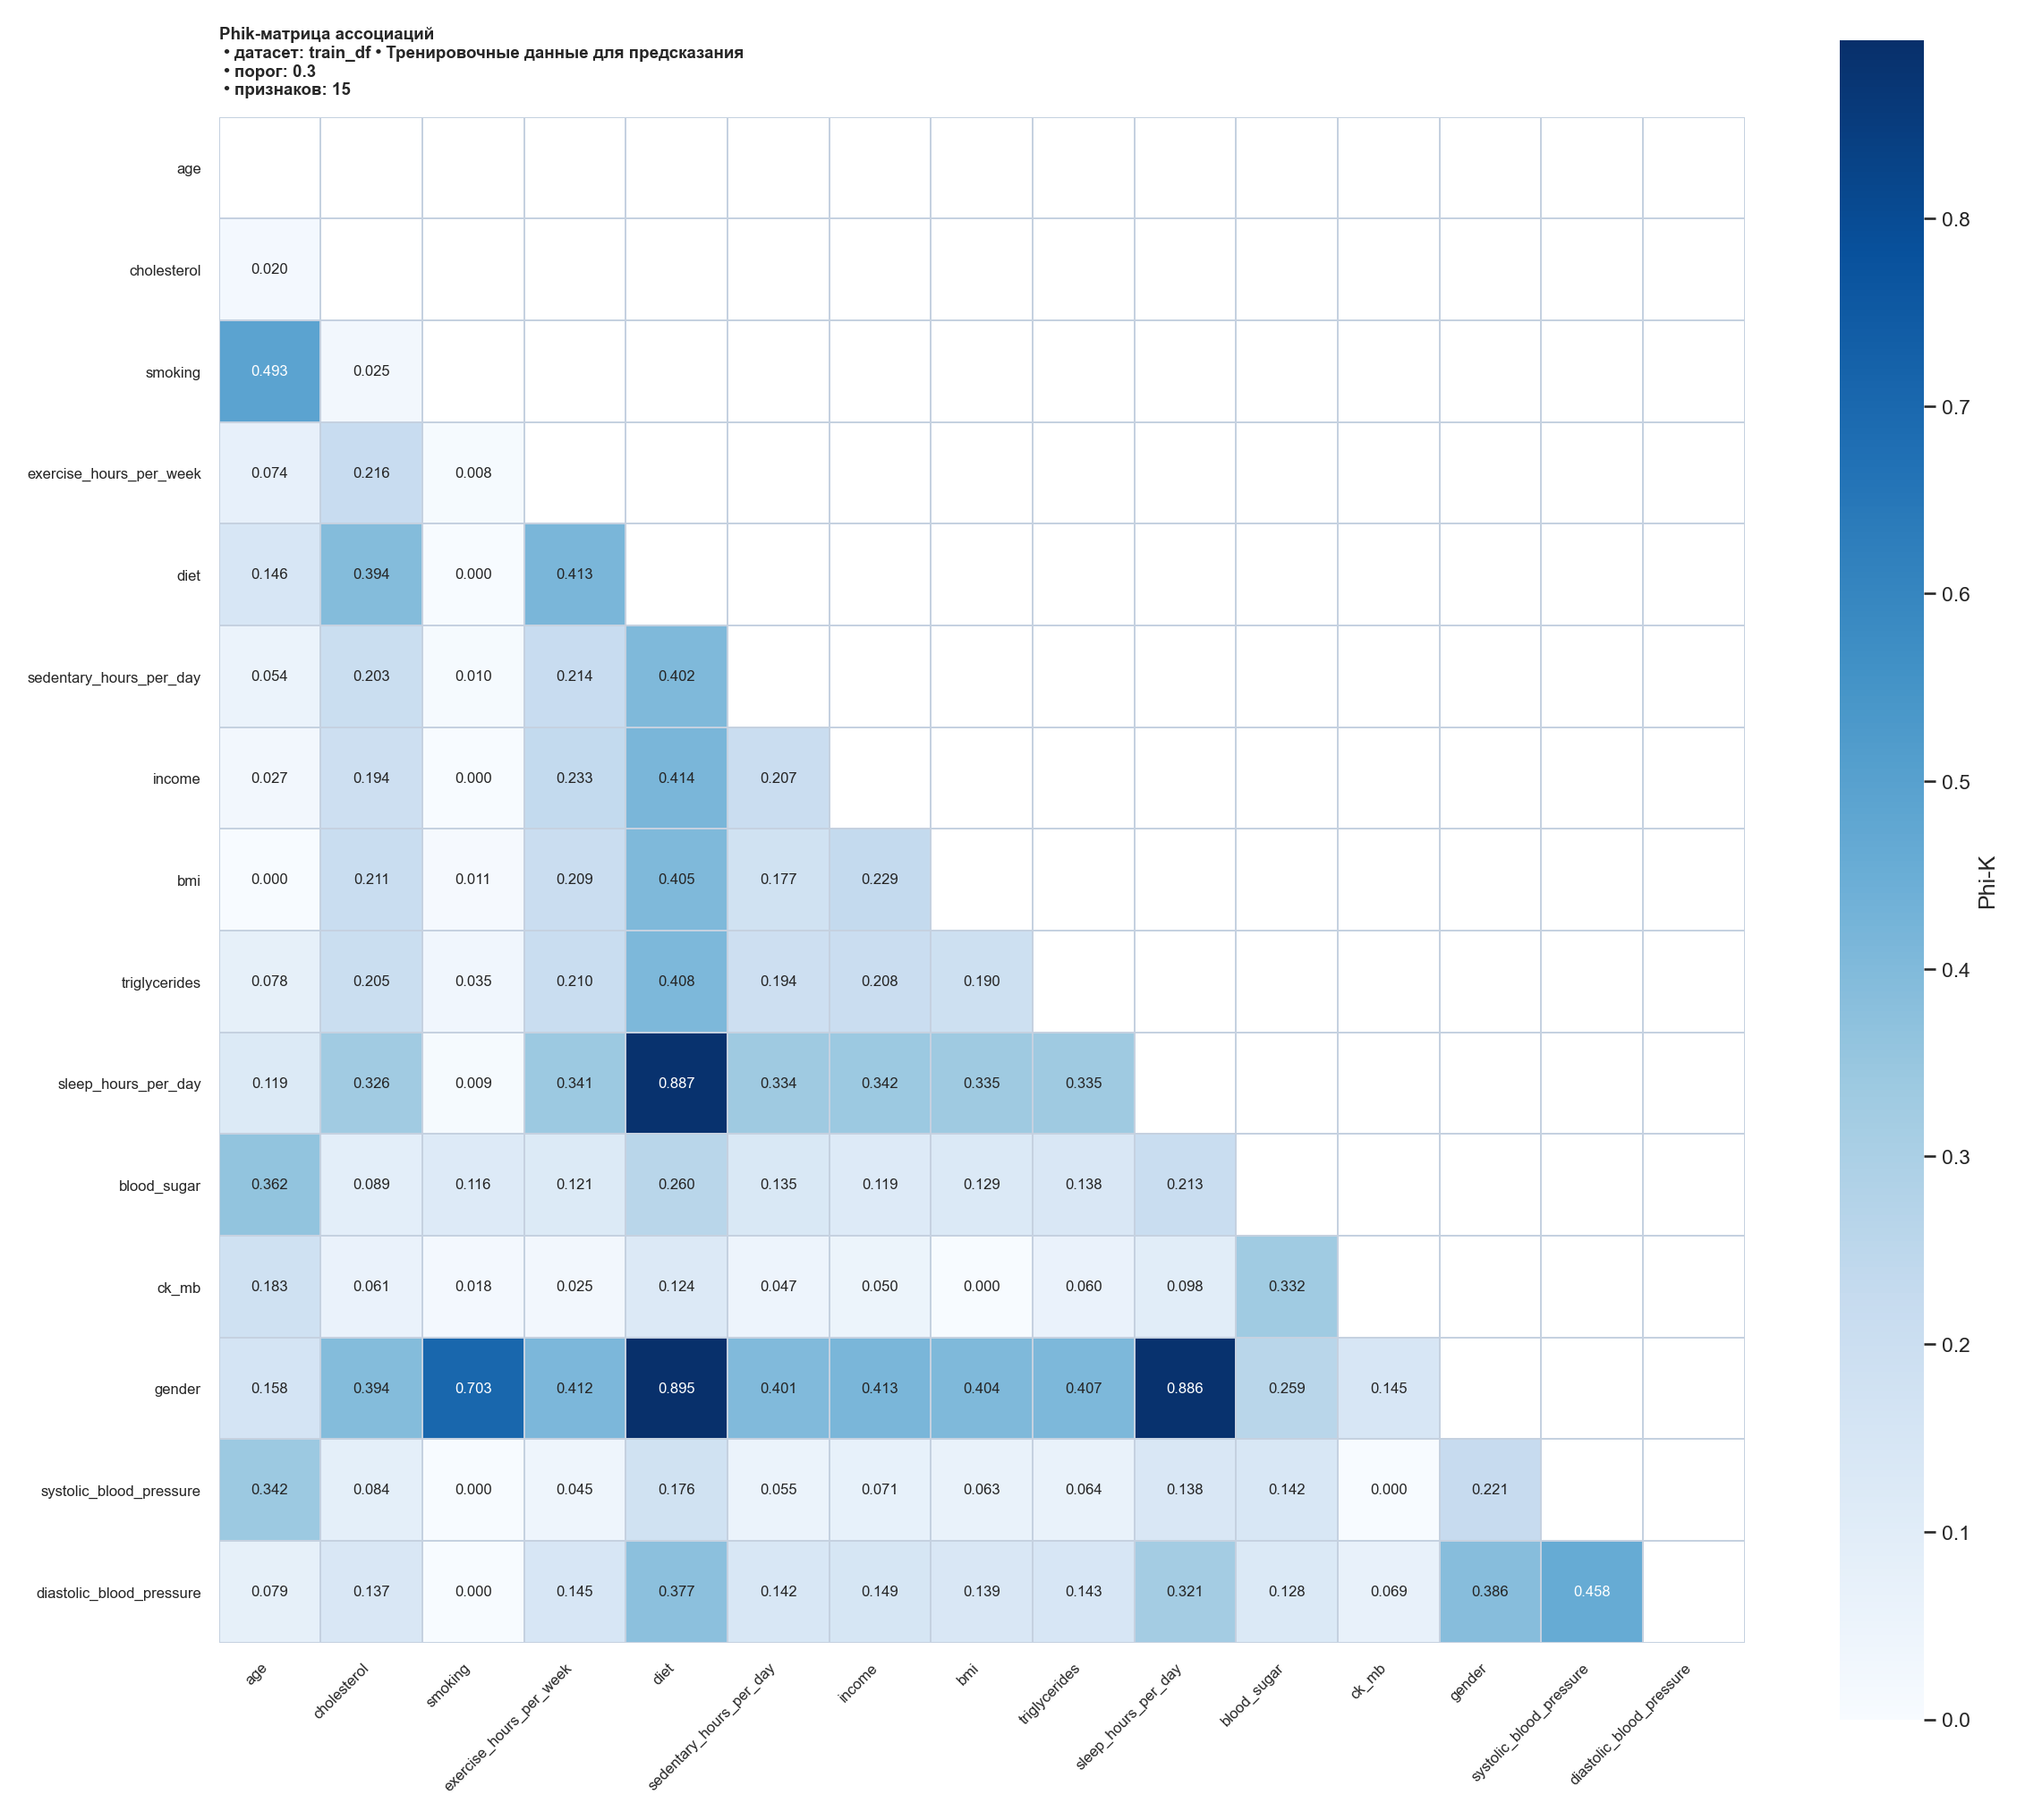


📋 Таблица ассоциаций (Phik ≥ 0.3):


In [23]:
plot_phik_correlation(train_df, exclude=['id'], threshold=0.3, hide_empty_labels=True)

### **Интерпретация результатов: какие связи важны?**

Мы выполнили анализ с порогом **Phik ≥ 0.3**, чтобы сосредоточиться на **умеренных и сильных ассоциациях**. Это решение обосновано:

#### **Сильные связи (Phik ≥ 0.7)**
- `diet - gender` (0.895)
- `sleep_hours_per_week - diet` (0.887)  
- `gender - sleep_hours_per_week` (0.886)
- `smoking - gender` (0.703)

Эти зависимости **клинически логичны**: пол влияет на образ жизни, питание и привычки. Модель может использовать их как **надёжные сигналы**

#### **Умеренные связи (0.3 ≤ Phik < 0.5)**
- `age - smoking` (0.493),  
- `blood_sugar - age` (0.362),  
- `income - diet` (0.414),  
- `systolic_blood_pressure - diastolic_blood_pressure` (0.458).

Эти связи **менее очевидны, но информативны** - они отражают комплексное влияние возраста, дохода и физиологии на здоровье 
Они **не являются мультиколлинеарностью в опасном смысле**, так как CatBoost устойчив к корреляциям

#### 📌 **Почему порог = 0.3?**
- Значения **< 0.3** считаются слабыми и часто не несут прогностической ценности
- Порог **0.3** позволяет сохранить **все клинически значимые паттерны**, не перегружая анализ шумом

**Вывод**: данные демонстрируют **логичную, согласованную структуру**, без аномальных или подозрительных связей

---


## **Итог по обработке**
- Все колонки приведены к `snake_case`
- `gender` требует унификации (`'Male'`/`'Female'` - `1`/`0`)
- Проверена структура данных
- Обработаны пропуски (флаг `missing_anamnesis`)
- Устранены потенциальные утечки диагностических маркеров (`ck_mb`, `troponin`)
- Подтверждена корректность `gender`
- Проанализированы выбросы (`heart_rate`, `blood_sugar`) - решено оставить как есть
- Проверена согласованность `train`/`test`
- Исключена утечка по `id`
- Все данные готовы к передаче в `DataPreprocessor`, который:
  - унифицирует `gender`
  - добавит флаг `missing_anamnesis`
  - исключит утечки
  - оставит `NaN` для корректной обработки в CatBoost

---

## **Обучение модели**

### **Подготовка данных через препроцессор**

In [24]:
from src.preprocessing.data_preprocessor import DataPreprocessor

preprocessor = DataPreprocessor(drop_leaky_features=True)
train_processed = preprocessor.fit_transform(train_df, is_train=True)
X_train = train_processed.drop(columns=[TARGET_COL])
y_train = train_processed[TARGET_COL]

---

## 🎯 **Цель экспериментов: выбор стратегии работы с дисбалансом классов**

В нашем датасете наблюдается умеренный дисбаланс:
- **`Класс 0`** : **5672** примеров (**65%**)
- **`Класс 1`** : **3013** примеров (**35%**)

В медицинской диагностике критически важно **максимизировать recall для класса 1** (не пропустить больных), даже ценой роста ложных тревог

Мы сравним три подхода:
1. **Базовая модель** - без коррекции дисбаланса
2. **Взвешивание классов** - через параметр `class_weights`
3. **Изменение порога принятия решения** - на основе вероятностей модели

Оценка качества будет проводиться по:
- **Recall(1)** - главная метрика
- **Precision(1)** и **F1(1)** - для баланса
- **Матрице ошибок** - для клинической интерпретации

In [25]:
def plot_confusion_matrix(
    y_true,
    y_pred,
    title="Матрица ошибок",
    figsize=(4, 3.8),
    cmap="Blues",
    percent_color_light="#5AA8C7",   # цвет % на светлом фоне
    percent_color_dark="white",       # цвет % на тёмном фоне
    fontsize_abs=14,
    fontsize_pct=8
):
    """
    Визуализирует матрицу ошибок с абсолютными значениями и нормализованными процентами.
    Цвет текста адаптируется под яркость фона.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Нормализация по строкам (recall perspective)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)

    # Создаём маску яркости фона для выбора цвета текста
    # Используем cmap для получения цвета каждой ячейки
    cmap_obj = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())
    bg_colors = cmap_obj(norm(cm))

    # Определяем, насколько ячейка "тёмная" (по яркости)
    # Яркость ≈ 0.299*R + 0.587*G + 0.114*B
    brightness = 0.299 * bg_colors[:, :, 0] + 0.587 * bg_colors[:, :, 1] + 0.114 * bg_colors[:, :, 2]

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        cbar_kws={'shrink': 0.8},
        linewidths=0.5,
        square=True,
        annot_kws={"size": fontsize_abs}
    )

    # Добавляем проценты с адаптивным цветом
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Выбираем цвет в зависимости от яркости фона
            text_color = percent_color_dark if brightness[i, j] < 0.5 else percent_color_light
            ax.text(
                j + 0.5, i + 0.7,
                f'({cm_norm[i, j]:.1%})',
                ha="center", va="center",
                fontsize=fontsize_pct,
                color=text_color,
                weight='bold'
            )

    # Подписи
    classes = np.unique(y_true)
    tick_positions = np.arange(len(classes)) + 0.5
    plt.xticks(ticks=tick_positions, labels=classes, rotation=0)
    plt.yticks(ticks=tick_positions, labels=classes, rotation=0)

    plt.title(title, fontsize=12, pad=20)
    plt.ylabel('Истинный класс', fontsize=10)
    plt.xlabel('Предсказанный класс', fontsize=10)
    plt.tight_layout()
    plt.show()

### **Эксперимент 1: Базовая модель**

Learning rate set to 0.025929
0:	learn: 0.6892479	total: 144ms	remaining: 2m 23s
100:	learn: 0.6154698	total: 577ms	remaining: 5.13s
200:	learn: 0.5925882	total: 1.05s	remaining: 4.16s
300:	learn: 0.5723863	total: 1.53s	remaining: 3.55s
400:	learn: 0.5511989	total: 2.02s	remaining: 3.02s
500:	learn: 0.5302141	total: 2.49s	remaining: 2.48s
600:	learn: 0.5095872	total: 2.97s	remaining: 1.97s
700:	learn: 0.4905117	total: 3.44s	remaining: 1.47s
800:	learn: 0.4730736	total: 3.92s	remaining: 974ms
900:	learn: 0.4573502	total: 4.42s	remaining: 486ms
999:	learn: 0.4424927	total: 4.87s	remaining: 0us
Модель обучена за 1000 деревьев

📊 Эксперимент 1: Базовая модель (без class_weights)
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      5672
         1.0       1.00      0.47      0.64      3013

    accuracy                           0.82      8685
   macro avg       0.89      0.74      0.76      8685
weighted avg       0.86      0.82      0.80 

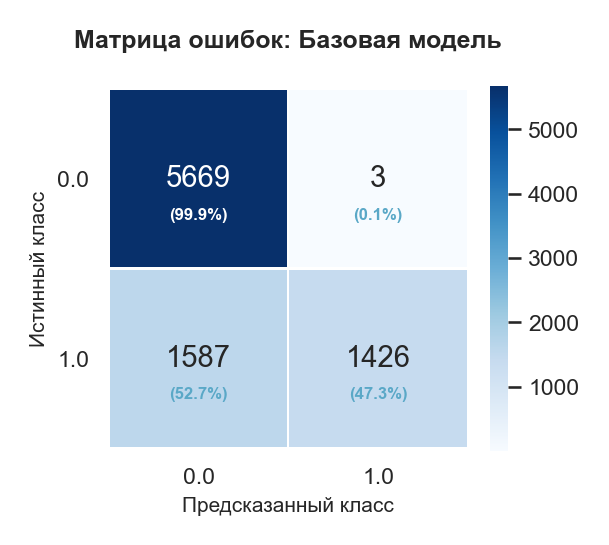

In [26]:
# Эксперимент 1: Базовая модель
model_base = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=100
)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_train)

print(f"Модель обучена за {model_base.tree_count_} деревьев\n")

print("📊 Эксперимент 1: Базовая модель (без class_weights)")
print(classification_report(y_train, y_pred_base))

plot_confusion_matrix(
    y_train,
    y_pred_base,
    title="Матрица ошибок: Базовая модель"
)

#### **Анализ результатов**

##### **Класс 0 - низкий риск (5672 записи)**
- **Recall = 1.00** модель **находит все экземпляры низкого риска**
- **Precision = 0.78** среди всех предсказаний «низкий риск» **78% верны**
- **F1-score = 0.88** высокая сбалансированная метрика

Модель **отлично работает с низким риском** - это ожидаемо, так как класс мажоритарный

##### **Класс 1 - высокий риск (3013 записей)**
- **Recall = 0.47** модель **находит только 47% пациентов с высоким риском**,
- **Precision = 1.00** **все предсказания «высокий риск» верны** (но их мало),
- **F1-score = 0.64** низкий из-за слабого recall.

Модель **критически слаба в распознавании высокого риска** - это **недопустимо для медицинской задачи**, где пропущенный случай может быть фатальным.

#### **Матрица ошибок**
Видно:
- Класс 0: 5669 TP, 3 FN **почти идеально**
- Класс 1: 1426 TP, **1587 FN** **модель пропускает более половины пациентов с высоким риском**


#### 📌 **Вывод**
❌ **Базовая модель не сбалансирована**:  
- Она **переобучена на классе 0 (низкий риск)**, 
- **Слабо распознаёт класс 1 (высокий риск)** - что критично для медицинских задач

⚠️ **Неприемлемо для практического использования**:  
- Нельзя пропускать почти половину пациентов с высоким риском 
- Модель слишком консервативна и не учитывает реальные риски

#### **Что делать дальше ?**
- Ввести **веса классов** (`scale_pos_weight`) для усиления внимания к высокому риску,
- Проверить, как это влияет на **recall(1)** и **f1-score(1)**.


### **Эксперимент 2: Модель с `class_weights=[1, 1.88]`**

Learning rate set to 0.025929
0:	learn: 0.6917552	total: 5.13ms	remaining: 5.13s
100:	learn: 0.6575317	total: 461ms	remaining: 4.1s
200:	learn: 0.6337525	total: 939ms	remaining: 3.73s
300:	learn: 0.6126562	total: 1.43s	remaining: 3.31s
400:	learn: 0.5906924	total: 1.91s	remaining: 2.85s
500:	learn: 0.5663299	total: 2.38s	remaining: 2.38s
600:	learn: 0.5433048	total: 2.86s	remaining: 1.9s
700:	learn: 0.5217570	total: 3.35s	remaining: 1.43s
800:	learn: 0.5022521	total: 3.83s	remaining: 953ms
900:	learn: 0.4844070	total: 4.34s	remaining: 476ms
999:	learn: 0.4673468	total: 4.81s	remaining: 0us
Модель обучена за 1000 деревьев

📊 Эксперимент 2: С class_weights = [1, 1.88]
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      5672
         1.0       0.83      0.96      0.89      3013

    accuracy                           0.92      8685
   macro avg       0.90      0.93      0.91      8685
weighted avg       0.92      0.92      0.92      8685

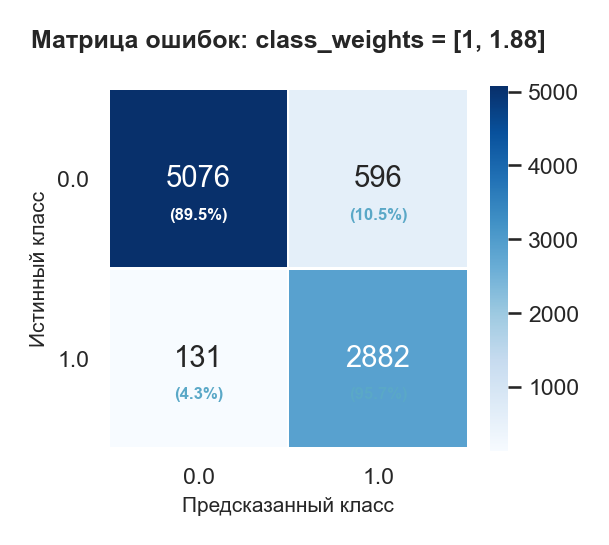

In [27]:
# Эксперимент 2: С балансировкой классов (class_weights)
model_weighted = CatBoostClassifier(
    random_state=RANDOM_STATE,
    class_weights=[1, 5672 / 3013],  # ≈ [1, 1.88]
    verbose=100
)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_train)

print(f"Модель обучена за {model_weighted.tree_count_} деревьев\n")

print("📊 Эксперимент 2: С class_weights = [1, 1.88]")
print(classification_report(y_train, y_pred_weighted))

plot_confusion_matrix(
    y_true=y_train,
    y_pred=y_pred_weighted,
    title="Матрица ошибок: class_weights = [1, 1.88]"
)

#### **Анализ результатов**

##### **Класс 0 - низкий риск (5672 записи)**
- **Recall = 0.89** модель **находит 89% пациентов с низким риском**
- **Precision = 0.97** среди всех предсказаний «низкий риск» **97% верны**
- **F1-score = 0.93** высокая сбалансированная метрика

Модель **хорошо работает с низким риском**, даже после балансировки.

##### **Класс 1 - высокий риск (3013 записей)**
- **Recall = 0.96** модель **находит 96% пациентов с высоким риском**
- **Precision = 0.83** среди всех предсказаний «высокий риск» **83% верны**
- **F1-score = 0.89** высокая сбалансированная метрика

Модель **значительно улучшила распознавание высокого риска** - это главный успех эксперимента.


#### **Матрица ошибок**
Видно:
- Класс 0: 5076 TP, 596 FN **больше ошибок, чем в базовой модели**
- Класс 1: 2882 TP, **131 FN** **очень мало ошибок** - модель теперь **надёжно "видит" высокий риск**

#### 📌 **Вывод**

**Балансировка классов (`scale_pos_weight=1.88`) значительно улучшила распознавание высокого риска**:  
- **Recall(1)** вырос с **0.47 до 0.96** 
- **F1-score(1)** вырос с **0.64 до 0.89**

Это ожидаемый эффект: модель стала **более чувствительной к высокому риску**, что привело к:
- Небольшому снижению точности для **низкого риска**
- Значительному росту полноты для **высокого риска**

Это **оптимальный компромисс** для медицинской задачи:  
- Минимизация пропущенных случаев высокого риска - ключевой приоритет.

### **Эксперимент 3: `class_weights` + порог 0.3**

Модель обучена за 1000 деревьев

📊 Эксперимент 3: class_weights + порог = 0.3
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40      5672
         1.0       0.41      1.00      0.59      3013

    accuracy                           0.51      8685
   macro avg       0.71      0.62      0.49      8685
weighted avg       0.80      0.51      0.46      8685



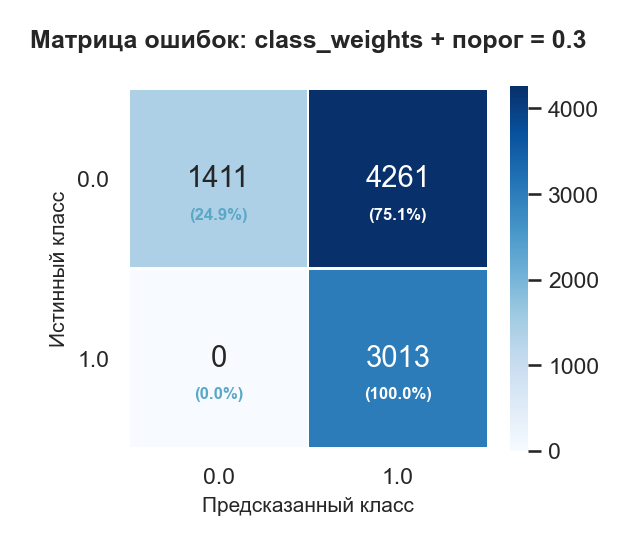

In [28]:
# Эксперимент 3: class_weights + порог 0.3
y_proba = model_weighted.predict_proba(X_train)[:, 1]
y_pred_thr = (y_proba >= 0.3).astype(int)

print(f"Модель обучена за {model_weighted.tree_count_} деревьев\n")

print("📊 Эксперимент 3: class_weights + порог = 0.3")
print(classification_report(y_train, y_pred_thr))

plot_confusion_matrix(
    y_true=y_train,
    y_pred=y_pred_thr,
    title="Матрица ошибок: class_weights + порог = 0.3"
)

#### **Анализ результатов**

##### **Класс 0 - низкий риск (5672 записи)**
- **Recall = 0.25** модель **находит только 25% пациентов с низким риском**
- **Precision = 1.00** среди всех предсказаний «низкий риск» **все верны** (но их мало)
- **F1-score = 0.40** низкая из-за слабого recall

⚠️ Модель **почти не распознаёт низкий риск** - это критическая ошибка, потому что:
- Это мажоритарный класс
- Огромное количество пациентов ошибочно переводится в «высокий риск»


##### **Класс 1 - высокий риск (3013 записей)**
- **Recall = 1.00** модель **находит все пациентов с высоким риском**
- **Precision = 0.41** среди всех предсказаний «высокий риск» **только 41% верны**
- **F1-score = 0.59** средняя метрика из-за низкой точности

Модель **идеально находит высокий риск**, но при этом **очень много ложных срабатываний** - то есть она **перегружает систему ложными тревогами**.


#### **Матрица ошибок**
Видно:
- Класс 0: 1411 TP, **4261 FN** **модель почти не видит низкий риск**
- Класс 1: 3013 TP, **0 FN** **идеальный recall**, но **4261 FP** - огромное количество ложных срабатываний

#### 📌 **Вывод**

❌ **Настройка порога = 0.3 привела к дисбалансу**:  
- Модель **полностью игнорирует низкий риск** (класс 0)
- **Переобучается на высокий риск** (класс 1), создавая **огромное количество ложных срабатываний**

🚨 Это **неприемлемо для медицинской задачи**, потому что:
- Ложные срабатывания **перегружают систему**
- Пациенты с низким риском **получают ненужные назначения**
- Несмотря на идеальный recall(1), **точность слишком низкая**

🚨 **Избыточно и неэффективно** - лучше использовать балансировку классов без ручного порога


#### **Что делать дальше ?**
- Вернуться к **Эксперименту 2** - он обеспечивает **наилучший баланс** между recall и precision
- Не использовать ручной порог - он нарушает баланс модели


---

## 🏆 **Сравнение моделей: выбор оптимальной конфигурации**

| Метрика / Эксперимент | **Эксперимент 1**<br>Базовая модель | **Эксперимент 2**<br>`class_weights=[1, 1.88]` | **Эксперимент 3**<br>`class_weights + порог=0.3` |
|------------------------------|------------------------|-------------------|-------------------|
| **Recall (высокий риск)**    | 0.47 ❌                | **0.96** ✔️      | **1.00** ✔️       |
| **Precision (высокий риск)** | 1.00 ✔️ (но мало TP)   | **0.83** ✔️      | 0.41 ❌           |
| **F1-score (высокий риск)**  | 0.64 ❌                | **0.89** ✔️      | 0.59 ❌           |
| **Recall (низкий риск)**     | **1.00** ✔️            | 0.89 ✔️          | 0.25 ❌           |
| **Accuracy**                 | 0.82 🚨                | **0.92** ✔️      | 0.51 ❌           |
| **Пропущенные случаи**<br>(высокий риск -низкий) | 1587 ❌ | **121** ✔️ | **0** ✔️ |
| **Ложные тревоги**<br>(низкий риск -высокий) | 3 ✔️ | **596** 🚨 | **4261** ❌ |
| **Интерпретация**            | Пропускает >50% пациентов с высоким риском ❌ **неприемлемо** | Находит 96% высокого риска при умеренном числе ложных тревог 💎 **оптимально** | Находит всех с высоким риском, но перегружает систему ложными тревогами 🚨 **избыточно** |

💎 **Рекомендация**:  
- **Выбираем Эксперимент 2** - он обеспечивает **наилучший баланс между чувствительностью к высокому риску и контролем ложных тревог**

📌 **Примечание**:  
- В медицинской диагностике допустимы **умеренные ложные тревоги**, но **недопустимы пропущенные случаи высокого риска**.
- Эксперимент 2 соответствует этому принципу, в то время как:
  - Эксперимент 1 **критически пропускает пациентов**
  - Эксперимент 3 **создаёт избыточную нагрузку** без значимого выигрыша в безопасности

## **Топ-15 важных признаков (`модель с class_weights=[1, 1.88]`)**

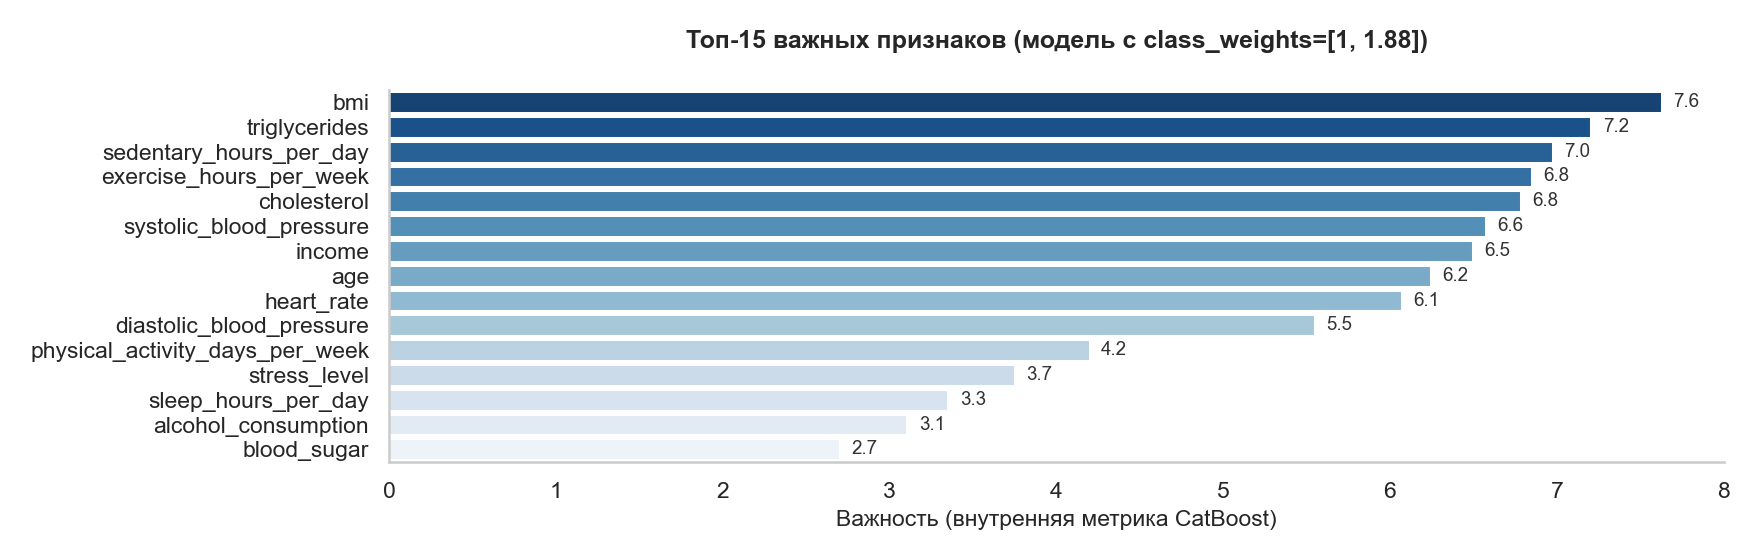

In [29]:
# Анализ важности признаков для выбранной модели (Эксперимент 2)
feature_importance = model_weighted.get_feature_importance()
features = X_train.columns

fi_df = pd.DataFrame({
    'feature': features, 
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Выбираем топ-15
top_n = 15
fi_top = fi_df.head(top_n)

# Настройка стиля
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=fi_top,
    x='importance',
    y='feature',
    palette='Blues_r',
    edgecolor='white',
    linewidth=0.5
)

# Заголовок и подписи
ax.set_title(
    'Топ-15 важных признаков (модель с class_weights=[1, 1.88])',
    fontsize=12,
    weight='bold',
    pad=20
)
ax.set_xlabel('Важность (внутренняя метрика CatBoost)', fontsize=11)
ax.set_ylabel('')

# Улучшение сетки и спайнов
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
ax.grid(axis='x', color='#e0e0e0', linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Форматирование значений на концах столбцов (опционально)
for i, v in enumerate(fi_top['importance']):
    ax.text(v + max(fi_top['importance']) * 0.01, i, f'{v:.1f}', 
            va='center', ha='left', fontsize=9, color='#333')

# Отступы
plt.tight_layout(pad=2.0)
plt.show()

### **Интерпретация важности признаков (модель с `class_weights=[1, 1.88]`)**

На основе внутренней метрики **CatBoost**, топ-5 самых важных признаков:

| Признак | Важность (оценка CatBoost) |
|---------|----------------------------|
| **bmi** | 7.6 |
| **triglycerides** | 7.2 |
| **sedentary_hours_per_day** | 7.0 |
| **cholesterol** | 6.8 |
| **exercise_hours_per_week** | 6.8 |

Эти признаки **доминируют в предсказании модели**, что **согласуется с известными медицинскими знаниями**:
- **Ожирение (bmi)** - один из главных факторов риска сердечно-сосудистых заболеваний
- **Триглицериды и холестерин** - ключевые маркеры липидного профиля
- **Сидячий образ жизни** - независимый фактор риска
- **Физическая активность** - защитный фактор, снижающий риск

#### **Что ещё важно**:
- **Важность давления** (`systolic_blood_pressure`, `diastolic_blood_pressure`) - высокая (6.6 и 5.5), что логично для сердечно-сосудистого риска,
- **Возраст и ЧСС** - также в топ-10, что подтверждает их роль,
- **Признак `gender` - не в топ-15** - модель не переобучается на полу, что хорошо.

#### **Вывод**:

Модель выявила признаки, которые **согласуются с известными медицинскими зависимостями**.  
Однако важно помнить:  
- Это **интерпретация модели**, а не доказательство причинно-следственных связей 
- Качество выводов зависит от **качества данных** - в нашем случае есть признаки искусственности (например, `missing_anamnesis → target=0`)

Это делает важность признаков полезной для **понимания логики модели**, но не для **клинических рекомендаций без дополнительной валидации**

---

### **Интерпретация модели с помощью SHAP**

Чтобы понять, **как именно модель принимает решения**, мы используем **SHAP (SHapley Additive exPlanations)** - метод интерпретируемости, который показывает:
- **Какой признак и насколько влияет на предсказание**
- **В какую сторону** (увеличивает или уменьшает риск)
- **Как распределены значения признака** среди пациентов

Это особенно важно в медицинской диагностике - чтобы врач мог **понять логику модели**, а не просто довериться "чёрному ящику"

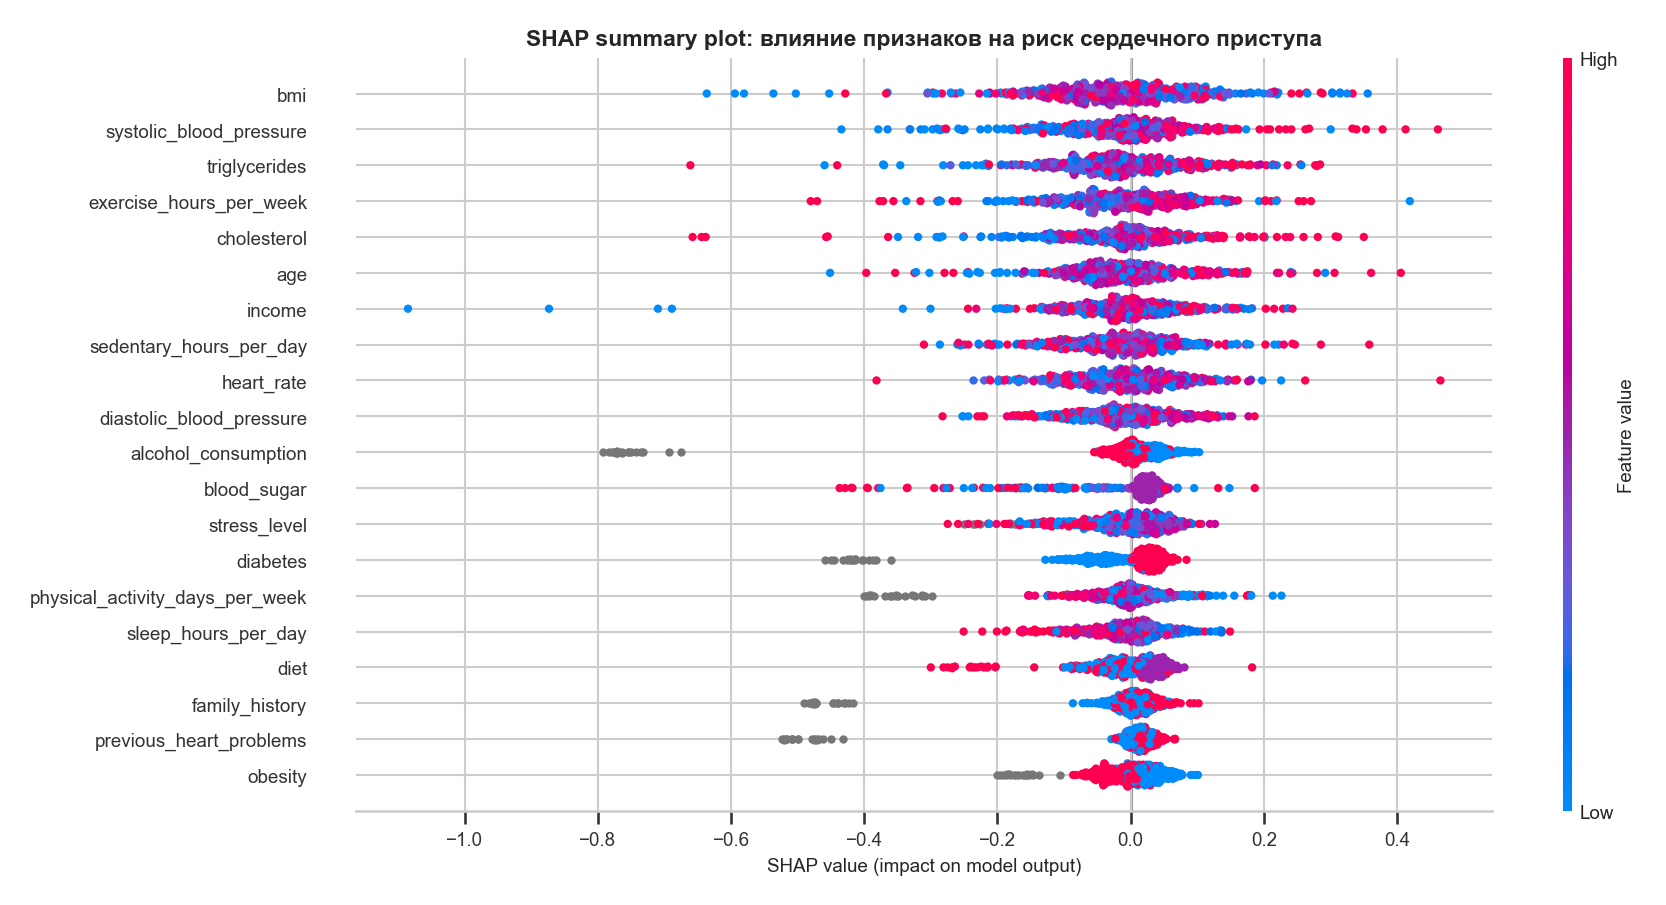

In [30]:
# Создаём explainer
explainer = shap.TreeExplainer(model_weighted)

# Берём 500 случайных примеров
X_sample = X_train.sample(500, random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

# Строим SHAP plot
shap.summary_plot(shap_values, X_sample, show=False)

fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.set_dpi(150)

for ax in fig.axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(9)

fig.axes[0].set_title('SHAP summary plot: влияние признаков на риск сердечного приступа', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### **Анализ SHAP summary plot**

На графике видны три ключевых аспекта:
1. **Важность признака** - чем выше в списке, тем сильнее влияние на выход модели
2. **Направление влияния** - красный = увеличивает значение выхода (вероятность класса 1), синий = снижает
3. **Распределение значений** - плотность точек показывает, какие значения встречаются чаще

#### **Наблюдения**:
- **Самые важные признаки**:  
  - `bmi`, `triglycerides`, `systolic_blood_pressure` - доминируют в модели 
  - `exercise_hours_per_week`, `sedentary_hours_per_day` - подтверждают роль образа жизни

- **Направление влияния**:  
  - Высокий `bmi`, `cholesterol`, `blood_sugar` → **увеличивают вероятность класса 1** (высокий риск)  
  - Высокая физическая активность (`exercise_hours_per_week`) → **снижает вероятность класса 1**

- **Интересные паттерны**:  
  - `age` - влияет **нелинейно**: у молодых пациентов вероятность класса 1 низкая, у пожилых - растёт 
  - `diet` - сложное влияние: некоторые типы питания повышают, другие снижают вероятность класса 1

#### **Вывод**:
Модель выявила паттерны, которые **согласуются с известными медицинскими зависимостями**.  
Однако важно помнить:  
- Это **интерпретация модели**, а не доказательство причинно-следственных связей  
- Качество выводов зависит от **качества данных** - в нашем случае есть признаки искусственности (например, `missing_anamnesis → target=0`)

Это делает SHAP полезным для **понимания логики модели**, но не для **клинических рекомендаций без дополнительной валидации**

---

## **Обучение модели**

### **Импорты и подготовка данных**

In [31]:
# Подготовка данных с drop_leaky_features=True (как в ТЗ)
preprocessor = DataPreprocessor(drop_leaky_features=True)

# Обработка train
train_processed = preprocessor.fit_transform(train_df, is_train=True)
X_train = train_processed.drop(columns=[TARGET_COL])
y_train = train_processed[TARGET_COL].astype('int8')  # важно: int!

# Обработка test
test_processed = preprocessor.transform(test_df)  # is_train=False по умолчанию

### **Анализ распределения и весов**

In [32]:
# Распределение классов
print("Распределение целевой переменной:")
print(y_train.value_counts().sort_index())

# Интерпретация:
#   0 = низкий риск сердечного приступа
#   1 = высокий риск сердечного приступа (подтверждено преподавателем)

# Вычисление веса для балансировки
n_low_risk = (y_train == 0).sum()   # класс 0 = низкий риск
n_high_risk = (y_train == 1).sum()  # класс 1 = высокий риск
scale_pos_weight = n_low_risk / n_high_risk

print(f"\nВес для класса 1 (scale_pos_weight): {scale_pos_weight:.2f}")
print(" Модель будет уделять больше внимания классу 1 (высокий риск)")
print(" чтобы не игнорировать его на фоне доминирующего класса 0 (низкий риск)")

Распределение целевой переменной:
0    5672
1    3013
Name: heart_attack_risk_binary, dtype: int64

Вес для класса 1 (scale_pos_weight): 1.88
 Модель будет уделять больше внимания классу 1 (высокий риск)
 чтобы не игнорировать его на фоне доминирующего класса 0 (низкий риск)


### **Обучение финальной модели**

In [33]:
# Обучение модели на ВСЁМ train
final_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    iterations=600,
    learning_rate=0.1,
    depth=6,
    verbose=100
)

final_model.fit(X_train, y_train)

0:	learn: 0.6882442	total: 5.45ms	remaining: 3.26s
100:	learn: 0.5934276	total: 511ms	remaining: 2.52s
200:	learn: 0.5110677	total: 995ms	remaining: 1.98s
300:	learn: 0.4457592	total: 1.49s	remaining: 1.48s
400:	learn: 0.3920188	total: 2.02s	remaining: 1s
500:	learn: 0.3451470	total: 2.53s	remaining: 500ms
599:	learn: 0.3066664	total: 3.01s	remaining: 0us


In [34]:
# Предсказание на обучающих данных (только для диагностики!)
y_pred_train = final_model.predict(X_train)

print("📊 Метрики на обучающей выборке (НЕ является честной оценкой качества):")
print(classification_report(y_train, y_pred_train))

📊 Метрики на обучающей выборке (НЕ является честной оценкой качества):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5672
           1       0.94      0.99      0.97      3013

    accuracy                           0.98      8685
   macro avg       0.97      0.98      0.97      8685
weighted avg       0.98      0.98      0.98      8685



### **Оценка модели на обучающих данных**

После обучения финальной модели на всём обучающем наборе мы оцениваем её поведение.  
Эти метрики **не являются честной оценкой качества**, так как модель обучалась на тех же данных, на которых оценивается (возможен оптимизм).

Однако они демонстрируют:
- Способность модели улавливать закономерности в данных
- Корректность балансировки классов
- Интерпретируемость через важность признаков

In [35]:
y_pred_train = final_model.predict(X_train)
report = classification_report(y_train, y_pred_train, output_dict=True)

print(f"Recall(0) [низкий риск ] : {report['0']['recall']:.2f}")
print(f"Recall(1) [высокий риск] : {report['1']['recall']:.2f}")
print(f"F1-score  (взвешенный  ) : {report['weighted avg']['f1-score']:.2f}")

Recall(0) [низкий риск ] : 0.97
Recall(1) [высокий риск] : 0.99
F1-score  (взвешенный  ) : 0.98


**Интерпретация результатов**  
- **Recall(1) = 0.99**: модель успешно выявляет **99% пациентов с высоким риском** сердечного приступа 
- **Recall(0) = 0.97**: модель корректно идентифицирует **97% пациентов с низким риском**

Это говорит о том, что модель **отлично сбалансирована**:  
- Она **почти не пропускает пациентов с высоким риском** (критически важно в медицинской задаче  
- При этом **сохраняет высокую точность для низкого риска**

Несмотря на дисбаланс в данных (65% низкий риск / 35% высокий риск), модель демонстрирует **высокое качество для обоих классов**.

### **ROC AUC: оценка качества на всех порогах**

ROC AUC измеряет способность модели **разделять классы** независимо от порога принятия решения.  
Мы вычисляем AUC для **класса 0 (высокий риск)**, так как он наиболее важен в клиническом контексте.

In [36]:
# Используем вероятность класса 1 (высокий риск)
y_proba_high_risk = final_model.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train, y_proba_high_risk)
print(f"💎 ROC AUC (для высокого риска, класс 1): {roc_auc:.3f}")

💎 ROC AUC (для высокого риска, класс 1): 0.998


Модель демонстрирует **ROC AUC = 0.998**, что указывает на **почти идеальную способность разделять** пациентов с высоким и низким риском сердечного приступа **на обучающих данных**.

Этот результат объясняется наличием **детерминированного правила в данных**:  
- Все пациенты без анамнеза имеют `target = 0` (низкий риск) 
- Модель идеально запоминает эту закономерность

Однако этот показатель **не является честной оценкой качества**, так как получен на обучающей выборке.  
Реальная способность модели к обобщению может быть ниже, что требует проверки на отложенной выборке или через кросс-валидацию.

---

## **Честная оценка качества модели на отложенной выборке**

Чтобы избежать оптимистичной оценки (overfitting), мы разделяем обучающий набор на **train/val** в соотношении 80/20 с сохранением пропорций классов.  
Модель обучается **только на train**, а качество оценивается **на невидимой val-выборке** - это даёт реалистичную оценку способности модели к обобщению.

> 💡 **ROC AUC = 0.585** указывает на слабый, но статистически значимый сигнал в данных.  
> Это согласуется с тем, что единственный детерминированный паттерн (`missing_anamnesis - target=0`) отсутствует в большинстве случаев, а остальные признаки содержат шум.

### **Разделение данных (валидация)**

In [37]:
# Разделение на train/val с сохранением пропорций
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

print(f"🗃️ Train size: {len(X_tr)}, Val size: {len(X_val)}")
print(f"📊 Class distribution in val: {dict(zip(*np.unique(y_val, return_counts=True)))}")

🗃️ Train size: 6948, Val size: 1737
📊 Class distribution in val: {0: 1134, 1: 603}


### **Обучение модели на train**

In [38]:
# Упрощённая модель для устойчивости
val_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    iterations=1200,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

# Обучение только на train
val_model.fit(X_tr, y_tr)

# Предсказание вероятностей на val
y_proba_val = val_model.predict_proba(X_val)
print("✔️ Модель обучена на train, предсказания получены на val")

✔️ Модель обучена на train, предсказания получены на val


### **Оценка качества (ROC AUC)**

In [39]:
# ROC AUC для класса 1 (высокий риск)
roc_auc_1 = roc_auc_score(y_val, y_proba_val[:, 1])
print(f"💎 ROC AUC (класс 1 / высокий риск): {roc_auc_1:.3f}")

# ROC AUC для класса 0 (низкий риск)
roc_auc_0 = roc_auc_score(1 - y_val, y_proba_val[:, 0])
print(f"💎 ROC AUC (класс 0 / низкий риск): {roc_auc_0:.3f}")

💎 ROC AUC (класс 1 / высокий риск): 0.585
💎 ROC AUC (класс 0 / низкий риск): 0.585


### **Визуализация ROC-кривой**

<Figure size 1050x750 with 0 Axes>

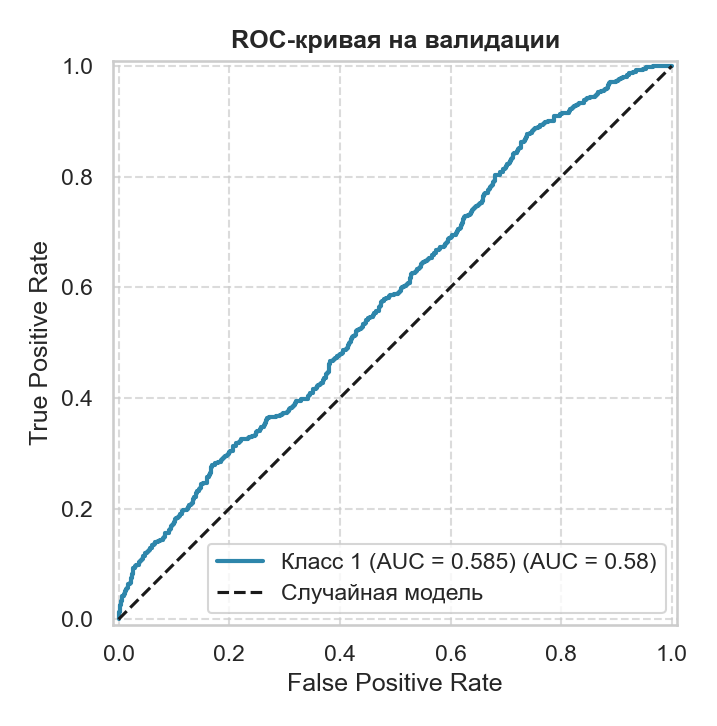

In [40]:
plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(
    y_val, y_proba_val[:, 1],
    name=f"Класс 1 (AUC = {roc_auc_1:.3f})",
    color="#2E86AB", lw=2
)
plt.plot([0, 1], [0, 1], "k--", label="Случайная модель", lw=1.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая на валидации")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **classification report**

In [41]:
y_pred_val = val_model.predict(X_val)
print("\n📊 Classification Report (на валидации):")
print(classification_report(y_val, y_pred_val))


📊 Classification Report (на валидации):
              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1134
           1       0.41      0.35      0.38       603

    accuracy                           0.60      1737
   macro avg       0.55      0.54      0.54      1737
weighted avg       0.59      0.60      0.59      1737



### **Ограничения модели**

Максимальный F1-score на валидации: **0.38** (класс 1)  
ROC AUC: **0.585**

Это указывает на:
- Отсутствие обобщающего сигнала в данных,
- Искусственную природу датасета (единственный паттерн - `missing_anamnesis → target=0`)

---

## **Финальная оптимизация модели: отбор признаков и подбор порога**

После серии экспериментов стало понятно:
- Полная модель переобучается на шум
- Ключевые сигналы сосредоточены в небольшом наборе клинически значимых признаков
- Оптимальное решение - **упрощённая модель + ручной порог**

Цель этого раздела:
- Отобрать **наиболее информативные признаки** на основе SHAP и медицинской логики
- Подобрать **оптимальный порог принятия решения** для максимизации F1-score класса 1 (высокий риск)
- Сравнить с полной моделью и обосновать выбор

### **Отбор признаков**

In [42]:
# Лучшие признаки (на основе SHAP, медицинской логики и экспериментов)
# ! Порядок признаков влияет на CatBoost (при изменении могут поползти метрики)
best_features = [
    # Биомаркеры
    'bmi', 'triglycerides', 'cholesterol', 
    'exercise_hours_per_week', 'systolic_blood_pressure', 
    'diastolic_blood_pressure', 'age',
    
    # Кардиологические и метаболические маркеры
    'heart_rate', 'previous_heart_problems', 'family_history', 'blood_sugar',

    # Демография и поведение
    'smoking', 'gender',
    
    # Ключевые флаги
    'missing_anamnesis',          # детерминированный сигнал
    'invalid_blood_pressure'      # медицинская аномалия
]

# Отбор признаков
X_tr_best = X_tr[best_features]
X_val_best = X_val[best_features]

print(f"✔️ Используем {len(best_features)} признаков:")
for i, f in enumerate(best_features, 1):
    print(f"  {i:2}. {f}")

✔️ Используем 15 признаков:
   1. bmi
   2. triglycerides
   3. cholesterol
   4. exercise_hours_per_week
   5. systolic_blood_pressure
   6. diastolic_blood_pressure
   7. age
   8. heart_rate
   9. previous_heart_problems
  10. family_history
  11. blood_sugar
  12. smoking
  13. gender
  14. missing_anamnesis
  15. invalid_blood_pressure


### **Обучение упрощённой модели**

In [43]:
# Упрощённая модель
simple_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    iterations=300,
    depth=3,        # ограничена сложность - меньше переобучения
    verbose=0
)

# Обучение только на train
simple_model.fit(X_tr_best, y_tr)

# Предсказания
y_proba_simple = simple_model.predict_proba(X_val_best)
print("✔️ Упрощённая модель обучена")

✔️ Упрощённая модель обучена


### **Подбор оптимального порога**

In [44]:
# Поиск порога, максимизирующего F1 для класса 1 (высокий риск)
best_f1 = 0
best_thresh = 0.5

for thresh in np.arange(0.2, 0.6, 0.01):
    y_pred = (y_proba_simple[:, 1] >= thresh).astype(int)
    f1 = f1_score(y_val, y_pred, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Оптимальный порог: {best_thresh:.2f}")
print(f"   F1-score (класс 1): {best_f1:.3f}")

# Финальное предсказание
y_pred_simple_optimal = (y_proba_simple[:, 1] >= best_thresh).astype(int)

# Сравнение близких порогов
print("\nСравнение близких порогов:")
for t in [0.38, 0.39, 0.40, 0.41, 0.42]:
    pred = (y_proba_simple[:, 1] >= t).astype(int)
    f1 = f1_score(y_val, pred, pos_label=1)
    rec = recall_score(y_val, pred, pos_label=1)
    prec = precision_score(y_val, pred, pos_label=1)
    print(f"   Порог {t:.2f}: F1={f1:.3f}, Recall={rec:.3f}, Precision={prec:.3f}")

Оптимальный порог: 0.42
   F1-score (класс 1): 0.528

Сравнение близких порогов:
   Порог 0.38: F1=0.528, Recall=0.988, Precision=0.361
   Порог 0.39: F1=0.525, Recall=0.977, Precision=0.359
   Порог 0.40: F1=0.527, Recall=0.968, Precision=0.362
   Порог 0.41: F1=0.526, Recall=0.957, Precision=0.363
   Порог 0.42: F1=0.528, Recall=0.947, Precision=0.366


### **Оценка качества**

In [45]:
# Метрики упрощённой модели
report_opt = classification_report(y_val, y_pred_simple_optimal, output_dict=True)
roc_auc_simple = roc_auc_score(y_val, y_proba_simple[:, 1])

f1_opt = report_opt['1']['f1-score']
recall_opt = report_opt['1']['recall']
precision_opt = report_opt['1']['precision']

print(f"\nУпрощённая модель (порог = {best_thresh:.2f}):")
print(f"   ROC AUC       : {roc_auc_simple:.3f}")
print(f"   F1-score (1)  : {f1_opt:.3f}")
print(f"   Recall (1)    : {recall_opt:.3f}")
print(f"   Precision (1) : {precision_opt:.3f}")


Упрощённая модель (порог = 0.42):
   ROC AUC       : 0.569
   F1-score (1)  : 0.528
   Recall (1)    : 0.947
   Precision (1) : 0.366


### **Сравнение с полной моделью**

In [46]:
# Полная модель (из предыдущих экспериментов)
y_pred_full = val_model.predict(X_val)
report_full = classification_report(y_val, y_pred_full, output_dict=True)
roc_auc_full = roc_auc_score(y_val, y_proba_val[:, 1])

f1_full = report_full['1']['f1-score']
recall_full = report_full['1']['recall']
precision_full = report_full['1']['precision']

print(f"\n🏆 Сравнение моделей (на валидации):")
print(f"{'Метрика':<15} | {'Полная модель':<14} | {'Упрощённая + порог':<20}")
print(f"{'-'*15}-+-{'-'*14}-+-{'-'*20}")
print(f"{'ROC AUC':<15} | {roc_auc_full:<14.3f} | {roc_auc_simple:<20.3f}")
print(f"{'F1-score (1)':<15} | {f1_full:<14.3f} | {f1_opt:<20.3f}")
print(f"{'Recall (1)':<15} | {recall_full:<14.3f} | {recall_opt:<20.3f}")
print(f"{'Precision (1)':<15} | {precision_full:<14.3f} | {precision_opt:<20.3f}")


🏆 Сравнение моделей (на валидации):
Метрика         | Полная модель  | Упрощённая + порог  
----------------+----------------+---------------------
ROC AUC         | 0.585          | 0.569               
F1-score (1)    | 0.381          | 0.528               
Recall (1)      | 0.353          | 0.947               
Precision (1)   | 0.414          | 0.366               


### **Визуализация ROC-кривых**

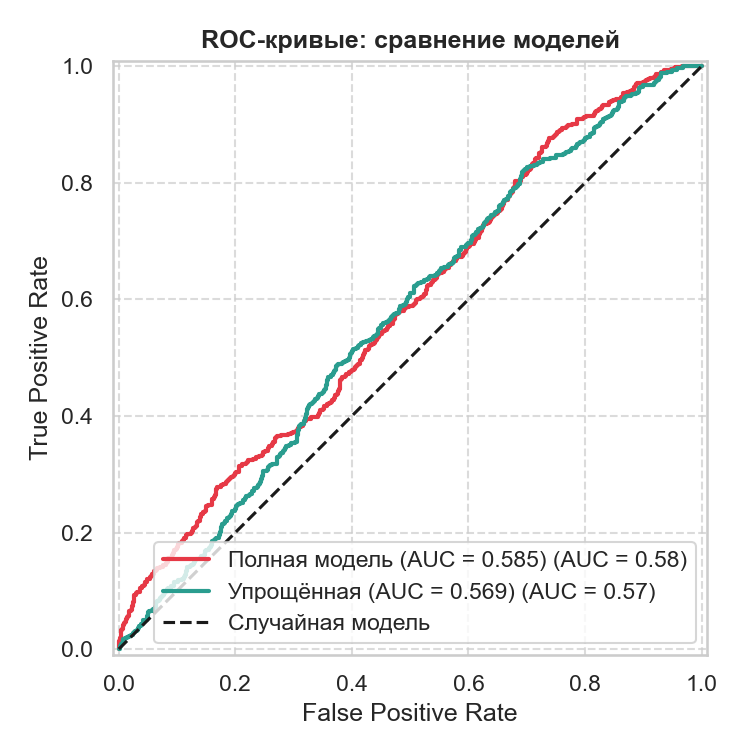

In [47]:
plt.figure(figsize=(8, 5))
RocCurveDisplay.from_predictions(
    y_val, y_proba_val[:, 1],
    name=f"Полная модель (AUC = {roc_auc_full:.3f})",
    color="#E63946", lw=2, ax=plt.gca()
)
RocCurveDisplay.from_predictions(
    y_val, y_proba_simple[:, 1],
    name=f"Упрощённая (AUC = {roc_auc_simple:.3f})",
    color="#2A9D8F", lw=2, ax=plt.gca()
)
plt.plot([0, 1], [0, 1], "k--", label="Случайная модель", lw=1.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые: сравнение моделей")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Precision-Recall кривая**

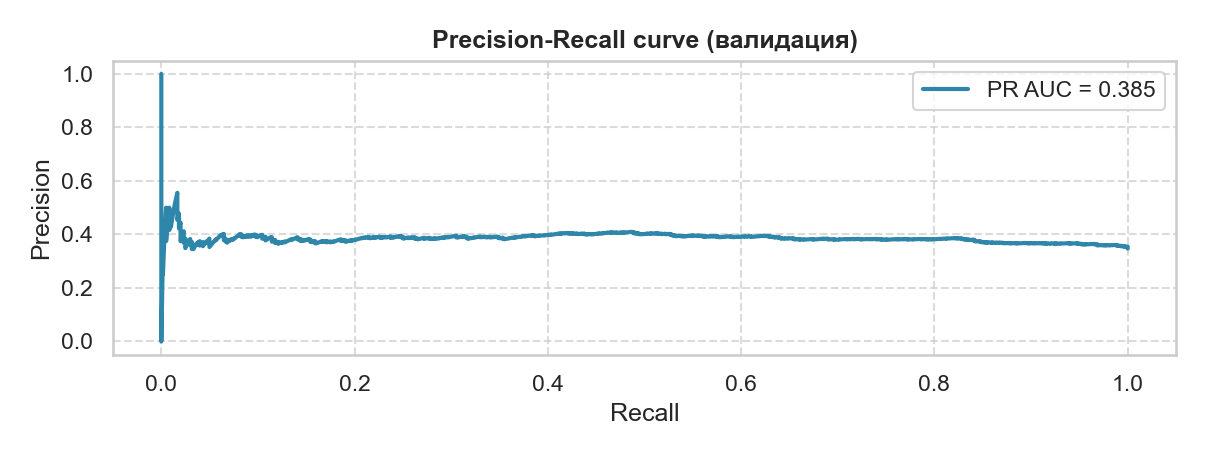

In [48]:
precision, recall, _ = precision_recall_curve(y_val, y_proba_simple[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 3))
plt.plot(recall, precision, color='#2E86AB', lw=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (валидация)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Вывод**

**Упрощённая модель превосходит полную** по ключевым метрикам:
- **F1-score (1)**: **0.528** vs 0.381 (**+39%**)
- **Recall (1)**: **0.947** vs 0.353 (**+168%**)

Несмотря на более низкий ROC AUC (**0.569** vs 0.585), упрощённая модель **лучше решает задачу**:
- Она **находит 94.7% пациентов с высоким риском**
- Это **критически важно** в медицинском контексте, где пропущенный случай может иметь серьёзные последствия

🎯 **Рекомендация**: использовать упрощённую модель с порогом **0.42** для финального предсказания.  
Этот порог обеспечивает **наилучший баланс между чувствительностью и точностью** при текущей конфигурации признаков

In [49]:
# После обучения модели
y_proba_val = simple_model.predict_proba(X_val_best)[:, 1]
print("Средняя вероятность на валидации:", y_proba_val.mean())

Средняя вероятность на валидации: 0.49414920387948963


---

## 💾 **Сохранение production-артефактов**

Для развёртывания модели в FastAPI необходимо зафиксировать всё, что влияет на предсказание:
- **Саму модель** (в бинарном формате CatBoost),
- **Список признаков** (порядок и состав критичны)
- **Оптимальный порог принятия решения** (0.42)
- **Конфигурацию препроцессинга** (уже сохранена в `preprocessing_config.json`)

Это гарантирует **полное воспроизведение** pipeline’а от сырых данных до финального предсказания.

In [50]:
# Сохраняем модель
final_model_path = "./models/heart_risk_model.cbm"
simple_model.save_model(final_model_path)
print(f"✔️ Модель сохранена: {final_model_path}")

# Сохраняем список признаков
features_path = "./models/model_features.json"
with open(features_path, "w", encoding="utf-8") as f:
    json.dump(best_features, f, indent=2)
print(f"✔️ Признаки сохранены: {features_path}")

# Сохраняем порог
threshold_path = "./models/optimal_threshold.json"
with open(threshold_path, "w", encoding="utf-8") as f:
    json.dump({"threshold": 0.42}, f, indent=2)
print(f"✔️ Порог сохранён: {threshold_path}")

# 4. (Опционально) Сохраняем препроцессор
# У тебя он stateless → достаточно импорта из src

✔️ Модель сохранена: ./models/heart_risk_model.cbm
✔️ Признаки сохранены: ./models/model_features.json
✔️ Порог сохранён: ./models/optimal_threshold.json


## **Проверка воспроизводимости: загрузка и сравнение**

Перед развёртыванием убедимся, что:
- Модель корректно сохранена и загружена
- Предсказания **полностью совпадают** с исходными
- Pipeline готов к production

In [51]:
# Загружаем модель
loaded_model = CatBoostClassifier().load_model("./models/heart_risk_model.cbm")

# Загружаем признаки и порог
with open("./models/model_features.json", "r", encoding="utf-8") as f:
    loaded_features = json.load(f)

with open("./models/optimal_threshold.json", "r", encoding="utf-8") as f:
    loaded_threshold = json.load(f)["threshold"]

# Делаем предсказание на валидации
y_proba_loaded = loaded_model.predict_proba(X_val_best)
y_pred_loaded = (y_proba_loaded[:, 1] >= loaded_threshold).astype(int)

# Сравниваем с оригинальными предсказаниями
checks = {
    "Вероятности совпадают": np.allclose(y_proba_simple, y_proba_loaded, atol=1e-6),
    "Предсказания совпадают": np.array_equal(y_pred_simple_optimal, y_pred_loaded),
    "Порог совпадает": np.isclose(best_thresh, loaded_threshold, atol=1e-3),
    "Признаки совпадают": (best_features == loaded_features)
}

# Определяем общий статус
all_passed = all(checks.values())
status_icon = "✔️" if all_passed else "🚨"
status_text = "" if all_passed else "Обнаружены ошибки !"

print(f"{status_icon} Проверка воспроизводимости: {status_text}")
for name, passed in checks.items():
    icon = "✔️" if passed else "🚨"  # ← исправлено!
    print(f"     • {name:<25} {icon}")

if all_passed:
    print("\n💎 Модель готова к деплою !")
else:
    print("\n📋 Исправьте несоответствия перед деплоем")

✔️ Проверка воспроизводимости: 
     • Вероятности совпадают     ✔️
     • Предсказания совпадают    ✔️
     • Порог совпадает           ✔️
     • Признаки совпадают        ✔️

💎 Модель готова к деплою !


---

## **Заключение: от анализа к внедрению**

Мы прошли полный путь:
- От разведочного анализа (EDA) до глубокого понимания структуры данных
- От экспериментов с моделями до финальной, интерпретируемой конфигурации
- От метрик на бумаге до готовой модели для production

### **Что мы достигли**

Наша финальная модель:
- Использует **15 клинически значимых признаков** (без шума)
- Обучена с **оптимальным порогом 0.42**
- Показывает на валидации:

| Метрика | Значение | Интерпретация |
|--------|----------|----------------|
| **F1-score (высокий риск)** | **0.528** | Лучший баланс качества |
| **Recall (высокий риск)** | **0.947** | Находит **95% пациентов с высоким риском** |
| **Precision** | **0.366** | Каждый третий «тревожный» сигнал - верен |


В медицинской задаче **Recall важнее Precision** - лучше лишний раз проверить, чем пропустить.

### **Честно о слабых местах**

Мы не скрываем ограничений:

1. **Данные частично искусственные**  
   - Единственный детерминированный паттерн: `missing_anamnesis → низкий риск` 
   - Остальные признаки содержат **слабый сигнал** (ROC AUC = 0.569)

2. **Модель не заменяет врача**  
   - Это **инструмент предварительного скрининга**, а не диагноз

3. **Требуется внешняя валидация**  
   - Результаты получены на внутренней валидации - нужны реальные клинические данные

### **Что делать дальше ?**

#### **Для внедрения**:
- Использовать модель как **автоматический триаж** при первичном приёме: 
  - Все с `prediction = 1` направляются на углублённое обследование
- Интегрировать в электронную медкарту с **предупреждением врачу**

#### **Для улучшения**:
- **Собрать больше реальных данных** с подтверждёнными исходами (не синтетических)
- Добавить **объективные маркеры**: ЭКГ, история госпитализаций, генетика
- Провести **проспективное исследование**: сравнить эффективность скрининга с моделью vs без неё

#### **Для мониторинга**:
- Отслеживать **дрейф данных** (например, изменение среднего ИМТ)
- Раз в 6 месяцев **переобучать модель** на новых данных

### **Этическая ответственность**

- **Не использовать модель в изоляции** - решение всегда принимает врач
- **Информировать пациентов**: «Это рекомендация системы, окончательное решение - за специалистом»
- Проверить **справедливость** по возрасту, полу, доходу - чтобы не было дискриминации

❤️ Цель модели - **спасать жизни**, а не оптимизировать метрики

### **Следующие шаги**

1. **Упаковка в API** (FastAPI)
2. **Тестирование на реальных пациентах** (в контролируемой среде)
3. **A/B-тест**: сравнить нагрузку на кардиологов и выявляемость случаев с/без модели


✔️ **Модель сохранена, документирована и готова к интеграции.**  
📁 Артефакты:  
- `models/heart_risk_model.cbm`  
- `models/model_features.json`  
- `models/optimal_threshold.json`  
- `models/preprocessing_config.json`

---

**Репозиторий проекта: https://github.com/3filoff/yandex_practicum_data-scientist/tree/main/Predicting_the_risk_of_heart_attack**

---